In [267]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform
from scipy.stats import boxcox
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoLarsIC, ElasticNet
%matplotlib inline
sns.set_style("whitegrid")

In [268]:
df_original = pd.read_csv('lung_dataframe_overall5.csv',converters={'Combined': lambda x: str(x),'State-county recode_x': lambda x: str(x)})

In [269]:
df = df_original.copy()
df.index = df['State_and_county']
df['2014_pop'] = df['2014_y_x']
df = df.iloc[:,61:]

df.head()


,2000cancer_rate,2001cancer_rate,2002cancer_rate,2003cancer_rate,2004cancer_rate,2005cancer_rate,2006cancer_rate,2007cancer_rate,2008cancer_rate,2009cancer_rate,...,2002_chems,2003_chems,2004_chems,2005_chems,2006_chems,2007_chems,2008_chems,2009_chems,2010_chems,2014_pop
State_and_county,,,,,,,,,,,,,,,,,,,,,
"Alameda County, CA",55.799261,48.316280,51.706237,51.988670,47.381203,48.905861,46.937176,48.429809,44.949662,51.316649,...,33885.076,35614.4750,31772.873398,40598.577567,21663.6730,19176.398300,29178.504200,26582.87500,16727.47440,1478621.0
"Butte County, CA",94.697434,94.086608,92.291507,83.222606,86.358623,77.764119,88.089879,75.413047,92.223125,79.626167,...,0.000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.00000,198402.0
"Contra Costa County, CA",54.470461,60.250146,53.476918,59.441172,52.195433,52.351671,54.754335,56.780346,52.181867,49.041806,...,56861.905,53506.3880,56955.025000,42611.428300,49675.2880,41985.616000,54775.177800,56356.25304,44899.43435,1005263.0
"Fresno County, CA",45.801260,45.632278,43.988517,43.791674,46.571858,45.617614,43.898256,43.306810,46.942163,43.300003,...,39701.663,43958.9795,43703.480600,42163.631714,34213.3234,30706.477261,19019.034072,2991.90230,7571.31840,891330.0
"Humboldt County, CA",71.958375,83.124216,80.757882,71.674091,82.630717,68.442626,80.246493,56.060181,61.813549,68.788133,...,74793.200,61044.1000,99790.800000,82488.600000,51491.6950,38042.545000,8855.575000,10.03500,7.76000,121751.0


Set thresholds for county size per group

In [270]:
large_counties = df[df['2014_pop']>500000]
medium_counties = df[(df['2014_pop']<=500000)&(df['2014_pop']>50000)]
small_counties = df[df['2014_pop']<50000]
print('Number of large counties:' + str(large_counties.shape))
print('Number of medium counties:' + str(medium_counties.shape))
print('Number of small counties:' + str(small_counties.shape))

Number of large counties:(25, 203)
Number of medium counties:(44, 203)
Number of small counties:(10, 203)


In [271]:
# df = medium_counties
# df_original = medium_counties

Isolate age and gender standardized cancer rates

In [272]:
cr = df.iloc[:,0:15]
cr['mean_cancer'] = cr.iloc[:,:14].mean(axis=1)
cr['mean_cancer_2004-2008'] = cr.iloc[:,4:9].mean(axis=1)
cr['mean_cancer_2009-2013'] = cr.iloc[:,9:14].mean(axis=1)
cancer_rates=cr.copy()
cancer_rates['State'] = df.State.values
cancer_rates['County'] = df.County.values
cancer_rates['State_and_county'] = df.State_and_county.values

In [273]:
cancer_rates.head()

,2000cancer_rate,2001cancer_rate,2002cancer_rate,2003cancer_rate,2004cancer_rate,2005cancer_rate,2006cancer_rate,2007cancer_rate,2008cancer_rate,2009cancer_rate,...,2011cancer_rate,2012cancer_rate,2013cancer_rate,2014cancer_rate,mean_cancer,mean_cancer_2004-2008,mean_cancer_2009-2013,State,County,State_and_county
State_and_county,,,,,,,,,,,,,,,,,,,,,
"Alameda County, CA",55.799261,48.316280,51.706237,51.988670,47.381203,48.905861,46.937176,48.429809,44.949662,51.316649,...,43.472046,42.750373,43.320816,41.644187,47.767503,47.320742,44.866175,CA,Alameda,"Alameda County, CA"
"Butte County, CA",94.697434,94.086608,92.291507,83.222606,86.358623,77.764119,88.089879,75.413047,92.223125,79.626167,...,73.186143,83.642282,68.432711,66.525579,83.502888,83.969759,76.978697,CA,Butte,"Butte County, CA"
"Contra Costa County, CA",54.470461,60.250146,53.476918,59.441172,52.195433,52.351671,54.754335,56.780346,52.181867,49.041806,...,54.683968,52.585598,52.009543,44.815310,54.019373,53.652730,52.073776,CA,Contra Costa,"Contra Costa County, CA"
"Fresno County, CA",45.801260,45.632278,43.988517,43.791674,46.571858,45.617614,43.898256,43.306810,46.942163,43.300003,...,43.594018,45.625256,42.777968,38.934705,44.645124,45.267340,43.896261,CA,Fresno,"Fresno County, CA"
"Humboldt County, CA",71.958375,83.124216,80.757882,71.674091,82.630717,68.442626,80.246493,56.060181,61.813549,68.788133,...,63.589243,59.407558,68.373528,63.119593,69.828067,69.838713,64.176962,CA,Humboldt,"Humboldt County, CA"


Text(0.5,0,'Mean County-wide Lung Cancer Incidence per 100,000, 2000-2013')

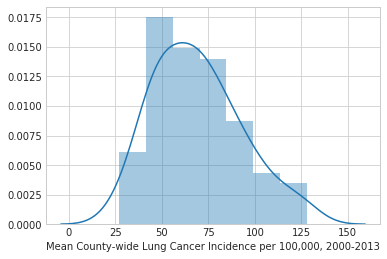

In [274]:
sns.distplot(cancer_rates['mean_cancer'])
plt.xlabel('Mean County-wide Lung Cancer Incidence per 100,000, 2000-2013', fontsize=10)

Text(0,0.5,'Incidence per 100,000')

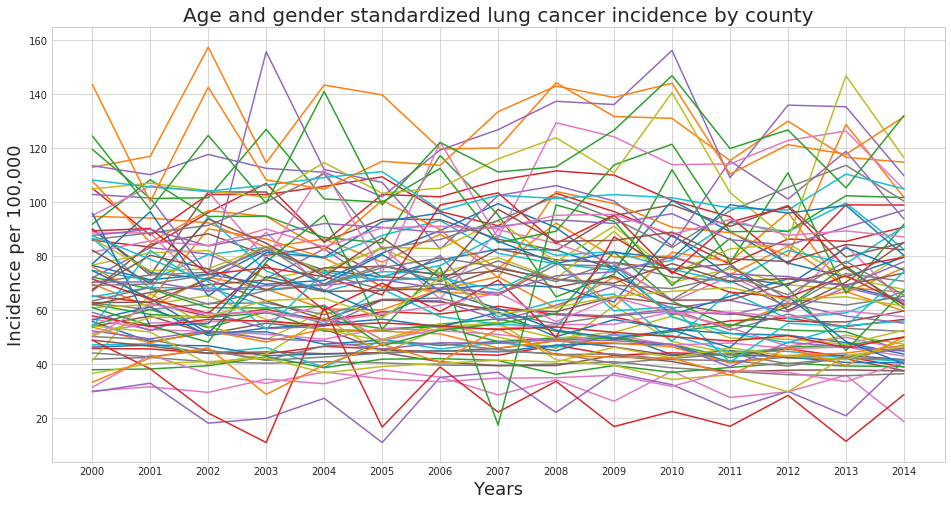

In [275]:
fig = plt.subplots(figsize=(16,8))
for row in cancer_rates.iloc[:,0:15].values:
    plt.plot_date(x=[i for i in cancer_rates.iloc[:,0:15].columns.str[:4]], y=row, fmt="-")
 
plt.title('Age and gender standardized lung cancer incidence by county', fontsize = 20)
plt.xlabel('Years', fontsize=18)
plt.ylabel('Incidence per 100,000', fontsize=18)

In [276]:
fips = pd.read_excel('FIPS.xlsx')
fips.FIPS = fips.FIPS.apply(lambda x: str(x).zfill(5))
fips['State_and_county'] = fips.Name + ' County, ' + fips.State

In [277]:
df_countywide = pd.melt(df.iloc[:,0:15].reset_index(), id_vars='State_and_county')
county_means = pd.DataFrame(df_countywide.groupby('State_and_county')['value'].mean()).reset_index()
df_countywide['mean'] = pd.merge(df_countywide, county_means, how='left', on='State_and_county')['value_y']
df_countywide['state'] = df_countywide['State_and_county'].str[-2:]
#df_countywide['FIPS'] = pd.merge(df_countywide, fips, how='left', on='State_and_county')['FIPS'].astype(str)
df_countywide = df_countywide.sort_values(by=['mean','value'])
#df_countywide['value'] = df_countywide['value'].astype(int).astype(str)
counties = df_countywide.State_and_county.unique()
county_lookup = dict(zip(counties, range(len(counties))))
df_countywide['county_num'] =  df_countywide.State_and_county.replace(county_lookup).values

df_countywide.head(30)
#pd.merge(df_countywide, county_means, how='left', on='State_and_county')

,State_and_county,variable,value,mean,state,county_num
280,"Delaware County, IA",2003cancer_rate,10.995052,27.831299,IA,0
1070,"Delaware County, IA",2013cancer_rate,11.429225,27.831299,IA,0
438,"Delaware County, IA",2005cancer_rate,16.708438,27.831299,IA,0
754,"Delaware County, IA",2009cancer_rate,16.896649,27.831299,IA,0
912,"Delaware County, IA",2011cancer_rate,16.995241,27.831299,IA,0
201,"Delaware County, IA",2002cancer_rate,21.892617,27.831299,IA,0
596,"Delaware County, IA",2007cancer_rate,22.245704,27.831299,IA,0
833,"Delaware County, IA",2010cancer_rate,22.511115,27.831299,IA,0
991,"Delaware County, IA",2012cancer_rate,28.444647,27.831299,IA,0
1149,"Delaware County, IA",2014cancer_rate,28.714179,27.831299,IA,0


Text(0.5,1,'Distribution of County Mean Lung Cancer Incidence per 100,000')

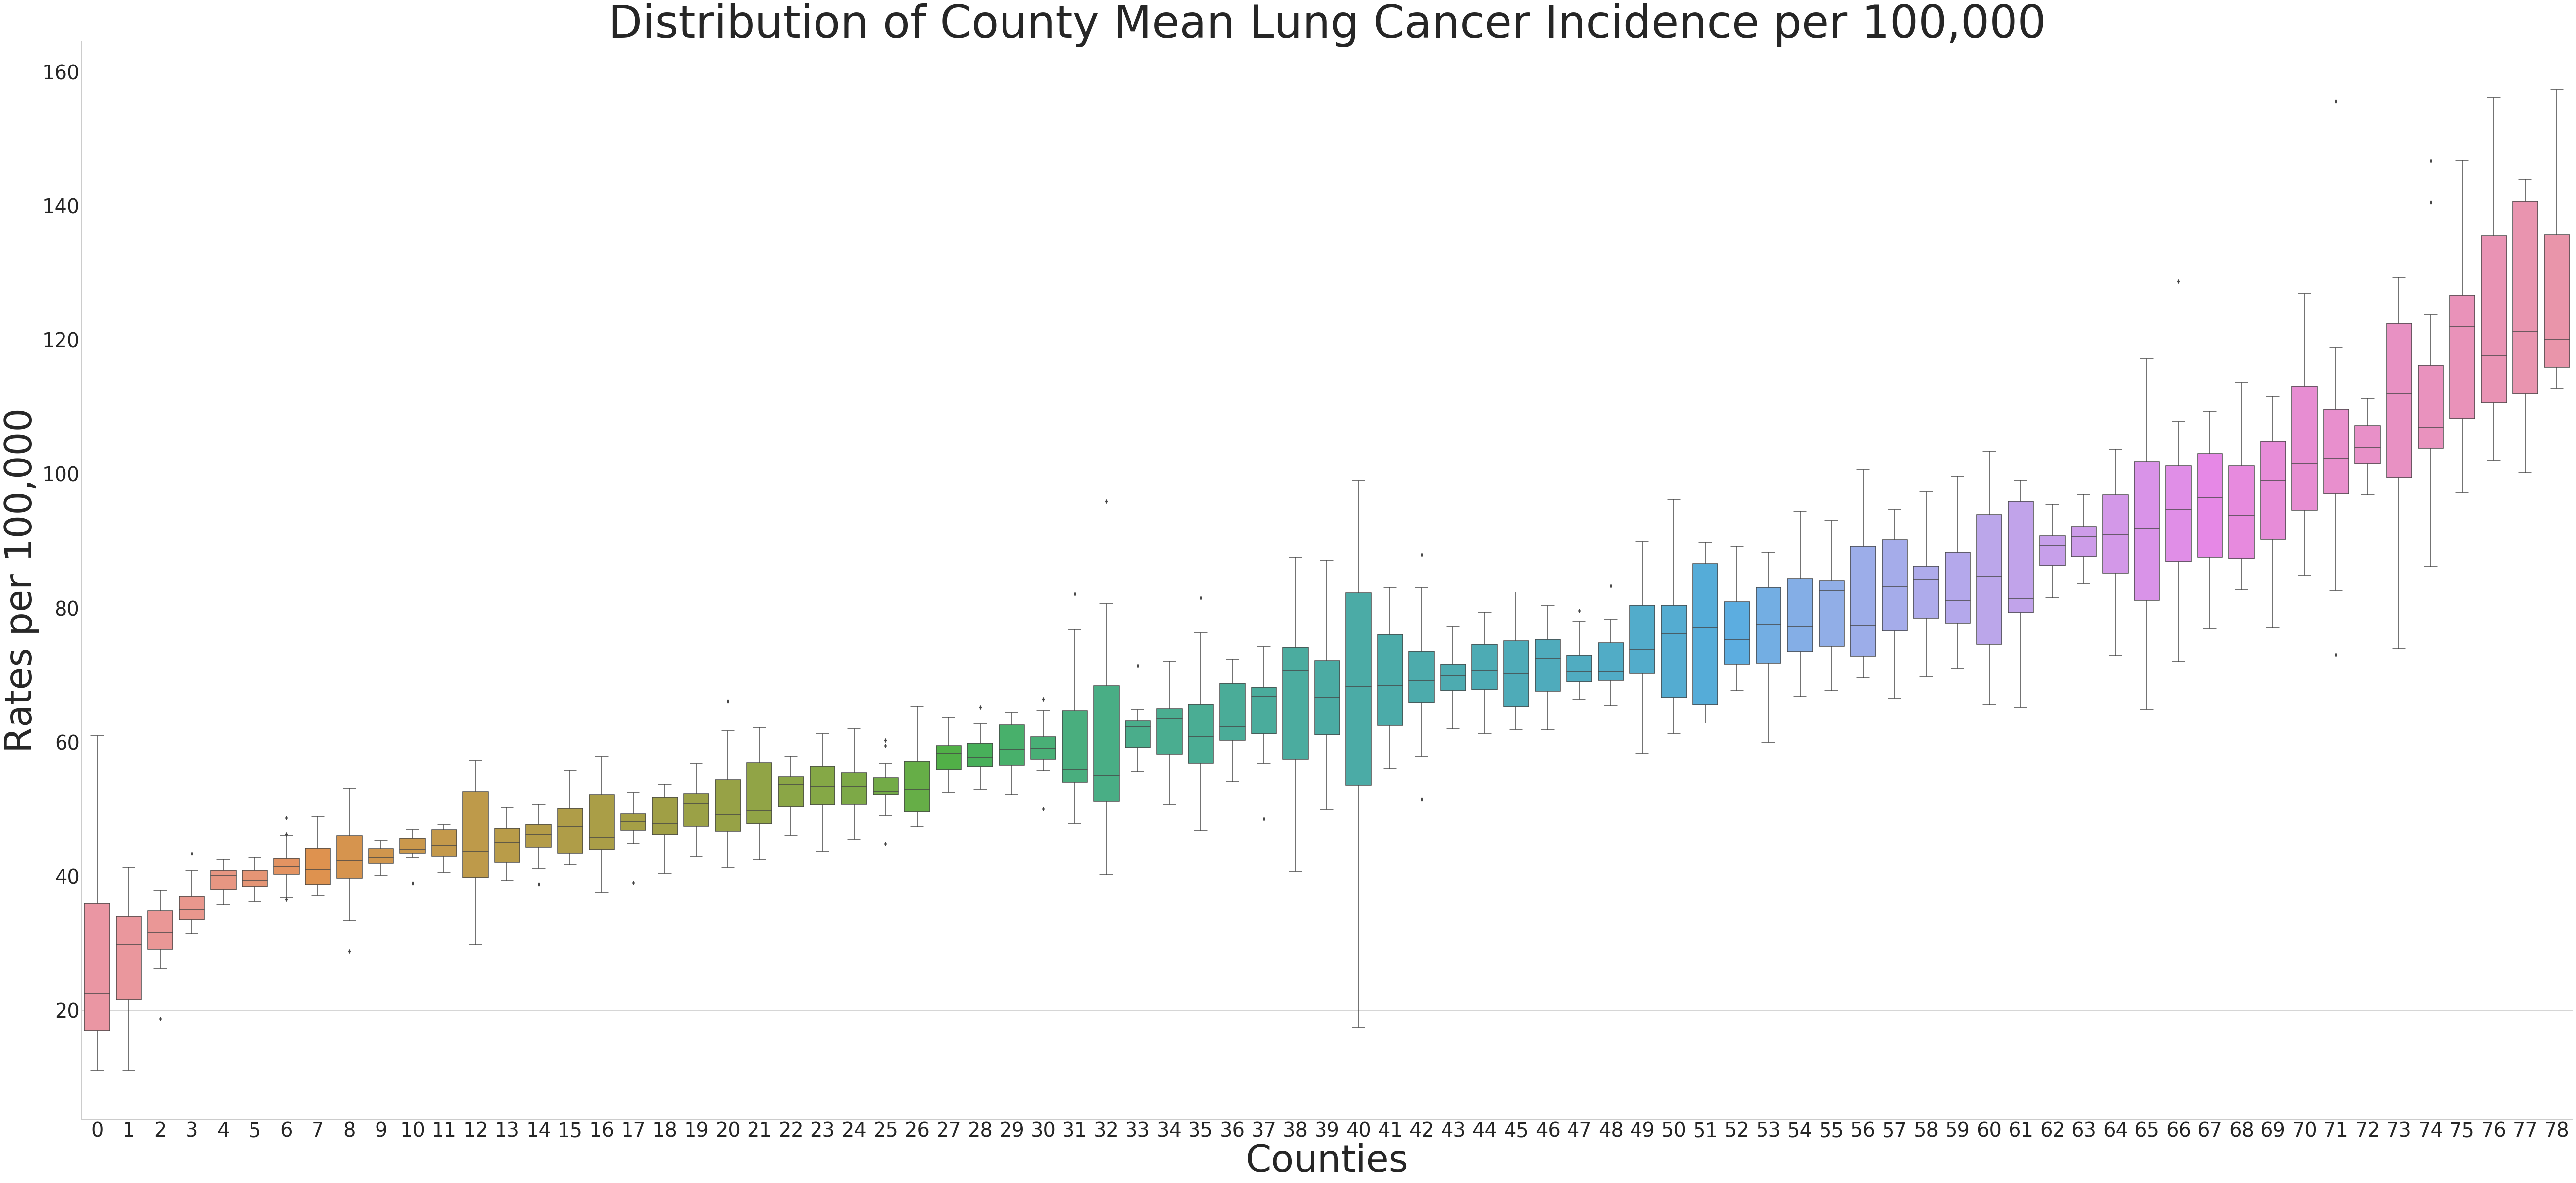

In [278]:
fig = plt.subplots(figsize=(90,40))
ax = sns.boxplot(x='county_num', y='value', data=df_countywide)

ax.set_xlabel('Counties', fontsize=75)
ax.set_ylabel('Rates per 100,000', fontsize=75)
#ax.set_yticklabels(ax.get_yticklabels(),rotation=90, fontsize=40)
#ax.set_xticklabels(df_countywide.county_num,rotation=45, fontsize=40)
ax.tick_params(labelsize=40)

plt.title('Distribution of County Mean Lung Cancer Incidence per 100,000', fontsize=90)

In [279]:
df_state = df_original.iloc[:,1:31]
df_state.index = df.State
df_state = pd.DataFrame(df_state.groupby(df_state.index)[df_state.columns].sum())
for i in range(2000, 2015):
    df_state[i] = (df_state[str(i)+"_x"]/df_state[str(i)+"_y_x"])*100000
    
df_state_rates = df_state.iloc[:,31:]
df_state_rates.head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
State,,,,,,,,,,,,,,
CA,54.054941,52.884778,52.457143,51.672228,52.020826,51.845971,50.843029,50.258682,51.694174,49.326992,47.460787,47.577054,47.138716,46.876723
GA,63.468915,64.722007,63.565976,61.187397,60.065612,60.470162,60.296692,61.239385,63.251062,57.074290,57.356341,59.796344,58.405575,59.460917
IA,84.671147,83.702998,86.302103,83.190553,86.926911,89.093912,93.409262,86.511228,88.729935,86.264107,85.254616,78.758755,83.761029,85.602275
KY,105.371914,103.528248,104.748389,106.953237,104.365245,102.598914,104.550904,104.828694,107.774672,106.693149,100.016698,103.001733,111.706931,102.744272
MI,88.822716,87.443777,92.221901,88.099285,91.766470,91.833086,94.388533,96.273043,95.604249,95.141800,93.377117,90.336070,92.086280,94.195294


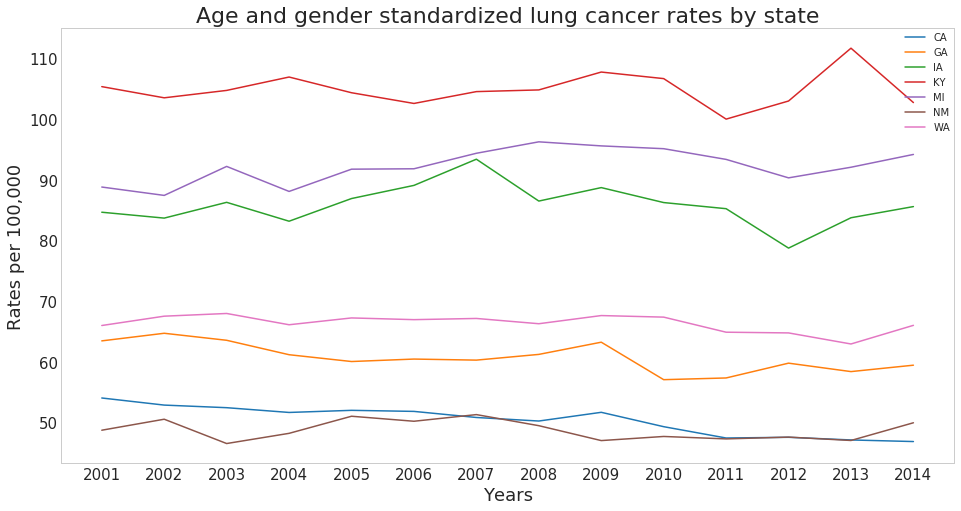

In [280]:
fig = plt.subplots(figsize=(16,8))
for row in df_state_rates.values:
    plt.plot_date(x=[str(i) for i in df_state_rates.columns], y=row, fmt="-")
plt.legend(df_state_rates.index, loc=1, borderaxespad=0.)
plt.title('Age and gender standardized lung cancer rates by state', fontsize = 22)
plt.xlabel('Years', fontsize=18)
plt.ylabel('Rates per 100,000', fontsize=18)
plt.tick_params(labelsize=15)
plt.grid(False)

Text(0.5,1,'Distribution of County Mean Lung Cancer Rates per 100,000 Grouped by State')

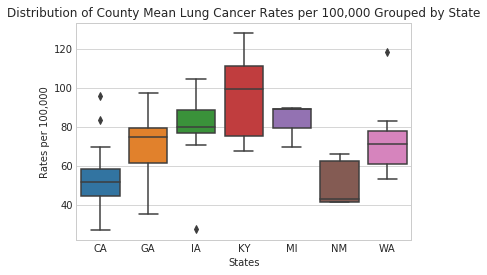

In [281]:
sns.boxplot(x='State', y='mean_cancer', data=cancer_rates)
plt.xlabel('States', fontsize=10)
plt.ylabel('Rates per 100,000', fontsize=10)
plt.title('Distribution of County Mean Lung Cancer Rates per 100,000 Grouped by State')

In [282]:
print ('Michigan counties: '+str(cancer_rates[cancer_rates['State']=='MI']['mean_cancer'].count()))
print ('California counties: '+str(cancer_rates[cancer_rates['State']=='CA']['mean_cancer'].count()))
print ('Kentucky counties: '+str(cancer_rates[cancer_rates['State']=='KY']['mean_cancer'].count()))
print ('Georgia counties: '+str(cancer_rates[cancer_rates['State']=='GA']['mean_cancer'].count()))
print ('New Mexico counties: '+str(cancer_rates[cancer_rates['State']=='NM']['mean_cancer'].count()))
print ('Iowa counties: '+str(cancer_rates[cancer_rates['State']=='IA']['mean_cancer'].count()))
print ('Washington counties: '+str(cancer_rates[cancer_rates['State']=='WA']['mean_cancer'].count()))
print ('Utah counties: '+str(cancer_rates[cancer_rates['State']=='UT']['mean_cancer'].count()))
print ('New Jersey counties: '+str(cancer_rates[cancer_rates['State']=='NJ']['mean_cancer'].count()))
print ('Connecticut counties: '+str(cancer_rates[cancer_rates['State']=='CT']['mean_cancer'].count()))

Michigan counties: 3
California counties: 29
Kentucky counties: 14
Georgia counties: 11
New Mexico counties: 5
Iowa counties: 10
Washington counties: 7
Utah counties: 0
New Jersey counties: 0
Connecticut counties: 0


Isolate smoking data by county;
Weight mean smoking % by ratio of county population to state population in order to show aggregated results

In [283]:
s = df.iloc[:,18:28]
s['mean_smoking'] = s.mean(axis=1)
s['mean_smoking_1996-2000'] = s.iloc[:,:5].mean(axis=1)
s['mean_smoking_2001-2005'] = s.iloc[:,5:10].mean(axis=1)
smoking = s.copy()
smoking['State'] = df.State.values
smoking['County'] = df.County.values
smoking['State_and_county'] = df.State_and_county.values
smoking['2014_pop'] = df['2014_pop']
smoking['State_pop'] = [smoking[smoking['State']==i]['2014_pop'].sum() for i in smoking.State.values]
smoking['Weighted Mean'] = smoking['mean_smoking'].values*(smoking['2014_pop'].values.astype(float)/smoking['State_pop'].values.astype(float))

smoking.head()

,1996smoking_total,1997smoking_total,1998smoking_total,1999smoking_total,2000smoking_total,2001smoking_total,2002smoking_total,2003smoking_total,2004smoking_total,2005smoking_total,mean_smoking,mean_smoking_1996-2000,mean_smoking_2001-2005,State,County,State_and_county,2014_pop,State_pop,Weighted Mean
State_and_county,,,,,,,,,,,,,,,,,,,
"Alameda County, CA",20.2,20.0,19.8,19.6,19.3,18.7,17.9,17.9,17.1,16.0,18.65,19.78,17.52,CA,Alameda,"Alameda County, CA",1478621.0,32826527.0,0.840061
"Butte County, CA",24.0,23.9,23.8,23.4,23.3,23.0,23.5,23.2,22.7,22.3,23.31,23.68,22.94,CA,Butte,"Butte County, CA",198402.0,32826527.0,0.140885
"Contra Costa County, CA",19.9,19.8,19.7,19.1,18.8,18.6,17.6,17.1,16.2,16.1,18.29,19.46,17.12,CA,Contra Costa,"Contra Costa County, CA",1005263.0,32826527.0,0.560104
"Fresno County, CA",21.3,21.3,21.3,21.5,20.9,20.3,20.8,19.7,20.0,19.2,20.63,21.26,20.00,CA,Fresno,"Fresno County, CA",891330.0,32826527.0,0.560161
"Humboldt County, CA",23.9,23.9,23.9,24.2,23.9,24.1,24.0,23.5,22.8,22.5,23.67,23.96,23.38,CA,Humboldt,"Humboldt County, CA",121751.0,32826527.0,0.087790


In [284]:
smoking.groupby('State')['Weighted Mean'].sum()

State
CA    19.452016
GA    22.790052
IA    25.615641
KY    29.168555
MI    27.124149
NM    24.735562
WA    21.745838
Name: Weighted Mean, dtype: float64

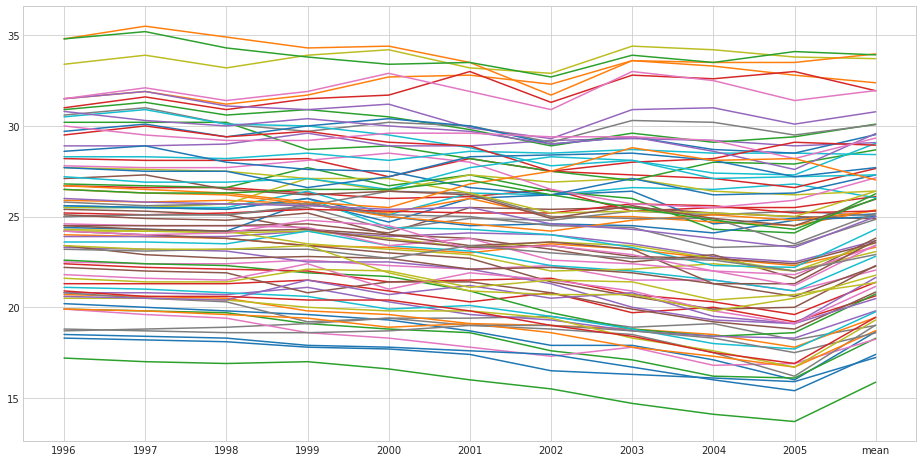

In [285]:
fig = plt.subplots(figsize=(16,8))
for row in smoking.iloc[:,:11].values:
    plt.plot_date(x=[i for i in smoking.iloc[:,:11].columns.str[:4]], y=row, fmt="-")

Text(0.5,1,'Daily/Nondaily Smokers,  Grouped by State')

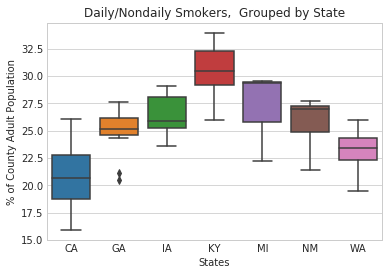

In [286]:
sns.boxplot(x='State', y='mean_smoking', data=smoking)
plt.xlabel('States', fontsize=10)
plt.ylabel('% of County Adult Population', fontsize=10)
plt.title('Daily/Nondaily Smokers,  Grouped by State')

In [287]:
sd = df.iloc[:,35:45]
sd['mean_smoking_daily'] = sd.mean(axis=1)
sd['mean_smoking_daily_1996-2000'] = sd.iloc[:,:5].mean(axis=1)
sd['mean_smoking_daily_2001-2005'] = sd.iloc[:,5:10].mean(axis=1)
smoking_daily = sd.copy()
smoking_daily['State'] = df.State.values
smoking_daily['County'] = df.County.values
smoking_daily['State_and_county'] = df.State_and_county.values
smoking_daily['2014_pop'] = df['2014_pop']
smoking_daily['State_pop'] = [smoking_daily[smoking_daily['State']==i]['2014_pop'].sum() for i in smoking_daily.State.values]
smoking_daily['Weighted Mean'] = smoking_daily['mean_smoking_daily'].values*(smoking_daily['2014_pop'].values.astype(float)/smoking_daily['State_pop'].values.astype(float))

smoking_daily.head()


,1996smoking_daily,1997smoking_daily,1998smoking_daily,1999smoking_daily,2000smoking_daily,2001smoking_daily,2002smoking_daily,2003smoking_daily,2004smoking_daily,2005smoking_daily,mean_smoking_daily,mean_smoking_daily_1996-2000,mean_smoking_daily_2001-2005,State,County,State_and_county,2014_pop,State_pop,Weighted Mean
State_and_county,,,,,,,,,,,,,,,,,,,
"Alameda County, CA",14.3,14.0,13.6,13.4,13.6,13.2,12.6,12.6,12.1,11.0,13.04,13.78,12.30,CA,Alameda,"Alameda County, CA",1478621.0,32826527.0,0.587367
"Butte County, CA",19.3,19.0,18.7,18.3,18.2,18.1,18.1,18.0,17.4,16.9,18.20,18.70,17.70,CA,Butte,"Butte County, CA",198402.0,32826527.0,0.110000
"Contra Costa County, CA",14.6,14.3,14.0,13.4,13.2,13.1,12.7,12.2,11.6,11.2,13.03,13.90,12.16,CA,Contra Costa,"Contra Costa County, CA",1005263.0,32826527.0,0.399024
"Fresno County, CA",15.3,15.1,14.9,15.2,15.0,14.5,14.9,14.1,14.2,13.5,14.67,15.10,14.24,CA,Fresno,"Fresno County, CA",891330.0,32826527.0,0.398331
"Humboldt County, CA",19.4,19.1,18.9,18.6,17.9,17.7,17.7,17.2,16.8,16.4,17.97,18.78,17.16,CA,Humboldt,"Humboldt County, CA",121751.0,32826527.0,0.066649


Text(0.5,1,'Daily Smokers,  Grouped by State')

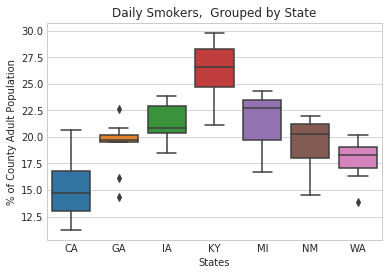

In [288]:
sns.boxplot(x='State', y='mean_smoking_daily', data=smoking_daily)
plt.xlabel('States', fontsize=10)
plt.ylabel('% of County Adult Population', fontsize=10)
plt.title('Daily Smokers,  Grouped by State')

In [289]:
pm = df.iloc[:,52:62]
pm['mean_pm25'] = pm.iloc[:,0:].mean(axis=1)
pm['mean_pm25_2001-2005'] = pm.iloc[:,:5].mean(axis=1)
pm['mean_pm25_2006-2010'] = pm.iloc[:,5:10].mean(axis=1)
pm_25 = pm.copy()
pm_25['State'] = df.State.values
pm_25['County'] = df.County.values
pm_25['State_and_county'] = df.State_and_county.values

pm_25.head()


,2001PM2.5,2002PM2.5,2003PM2.5,2004PM2.5,2005PM2.5,2006PM2.5,2007PM2.5,2008PM2.5,2009PM2.5,2010PM2.5,mean_pm25,mean_pm25_2001-2005,mean_pm25_2006-2010,State,County,State_and_county
State_and_county,,,,,,,,,,,,,,,,
"Alameda County, CA",13.007198,14.190016,12.459122,11.617424,11.197772,11.763339,11.182633,13.056139,10.936849,9.255255,11.866575,12.494306,11.238843,CA,Alameda,"Alameda County, CA"
"Butte County, CA",11.318704,12.909217,11.744747,11.366081,10.858977,11.083041,10.470951,14.972811,9.251522,7.670181,11.164623,11.639545,10.689701,CA,Butte,"Butte County, CA"
"Contra Costa County, CA",11.803491,13.294607,11.686306,11.280479,9.983341,10.571953,9.570334,11.803685,9.876394,8.734441,10.860503,11.609645,10.111361,CA,Contra Costa,"Contra Costa County, CA"
"Fresno County, CA",20.148444,21.778499,17.982144,16.673802,16.832094,17.309184,18.872574,17.609210,15.250828,13.262273,17.571905,18.682996,16.460814,CA,Fresno,"Fresno County, CA"
"Humboldt County, CA",8.511477,9.989389,9.480912,8.621484,7.695245,10.972586,7.868601,13.029956,8.432017,6.323943,9.092561,8.859701,9.325420,CA,Humboldt,"Humboldt County, CA"


Text(0.5,1,'Annual average ambient concentrations of PM 2.5 in micrograms per cubic meter')

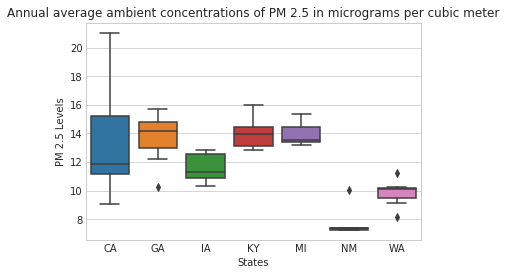

In [290]:
sns.boxplot(x='State', y='mean_pm25', data=pm_25)
plt.xlabel('States', fontsize=10)
plt.ylabel('PM 2.5 Levels', fontsize=10)
plt.title('Annual average ambient concentrations of PM 2.5 in micrograms per cubic meter')

In [291]:
oz = df.iloc[:,63:73]
oz['mean_ozone'] = oz.mean(axis=1)
oz['mean_ozone_2001-2005'] = oz.iloc[:,:5].mean(axis=1)
oz['mean_ozone_2006-2010'] = oz.iloc[:,5:10].mean(axis=1)
ozone = oz.copy()
ozone['State'] = df.State.values
ozone['County'] = df.County.values
ozone['State_and_county'] = df.State_and_county.values

ozone.head()

,2001Ozone,2002Ozone,2003Ozone,2004Ozone,2005Ozone,2006Ozone,2007Ozone,2008Ozone,2009Ozone,2010Ozone,mean_ozone,mean_ozone_2001-2005,mean_ozone_2006-2010,State,County,State_and_county
State_and_county,,,,,,,,,,,,,,,,
"Alameda County, CA",7.0,10.0,6.0,4.0,2.0,10.0,2.0,6.0,6.0,4.0,5.7,5.8,5.6,CA,Alameda,"Alameda County, CA"
"Butte County, CA",24.0,43.0,22.0,14.0,15.0,33.0,12.0,17.0,13.0,4.0,19.7,23.6,15.8,CA,Butte,"Butte County, CA"
"Contra Costa County, CA",9.0,9.0,8.0,4.0,2.0,14.0,1.0,9.0,3.0,4.0,6.3,6.4,6.2,CA,Contra Costa,"Contra Costa County, CA"
"Fresno County, CA",135.0,135.0,137.0,56.0,61.0,74.0,38.0,66.0,53.0,46.0,80.1,104.8,55.4,CA,Fresno,"Fresno County, CA"
"Humboldt County, CA",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CA,Humboldt,"Humboldt County, CA"


Text(0.5,1,'Number of days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard')

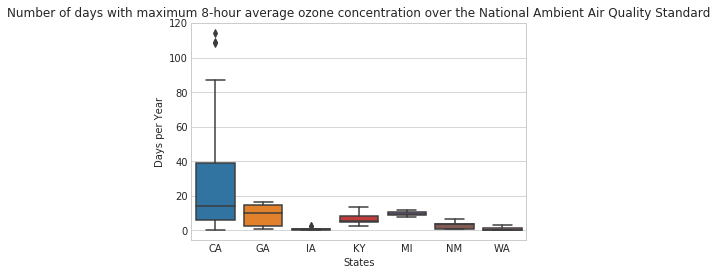

In [292]:
sns.boxplot(x='State', y='mean_ozone', data=ozone)
plt.xlabel('States', fontsize=10)
plt.ylabel('Days per Year', fontsize=10)
plt.title('Number of days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard')

Text(0.5,0,'Days of Harmful Levels of Ozone')

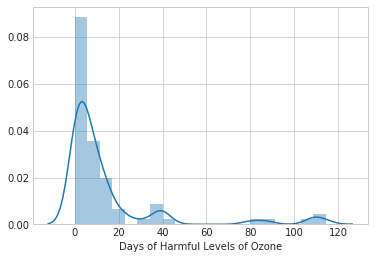

In [293]:
sns.distplot(oz.mean_ozone)
plt.xlabel('Days of Harmful Levels of Ozone', fontsize=10)

Text(0.5,0,'Log - Days of Harmful Levels of Ozone')

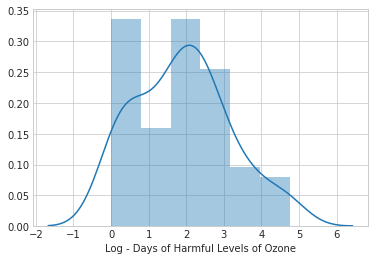

In [294]:
oz['log_ozone'] = oz[['mean_ozone']].applymap(lambda x: np.log(x+1))
sns.distplot(oz['log_ozone'])
plt.xlabel('Log - Days of Harmful Levels of Ozone', fontsize=10)

Text(0.5,0,'Mean Radon Levels (pCi/L)')

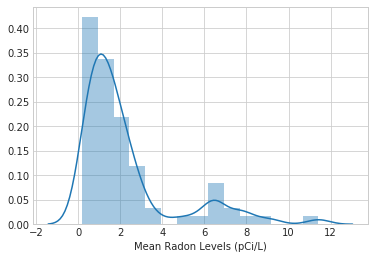

In [295]:
sns.distplot(df.radon_mean)
plt.xlabel('Mean Radon Levels (pCi/L)', fontsize=10)

Log transform radon data

In [296]:
df['log_radon'] = df[['radon_mean']].applymap(lambda x: np.log(x+1))

Text(0.5,0,'Mean Radon Levels (pCi/L)')

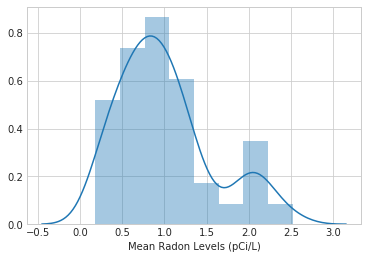

In [297]:
sns.distplot(df['log_radon'])
plt.xlabel('Mean Radon Levels (pCi/L)', fontsize=10)

In [298]:
aq = pd.concat([df.iloc[:,77:92],df.iloc[:,99:114],df.iloc[:,121:136], df.iloc[:,143:158], df.iloc[:,165:180]], axis=1)
aq['mean_median_aqi'] = aq.iloc[:,:15].mean(axis=1)
aq['mean_median_aqi_1996-2000'] = aq.iloc[:,:5].mean(axis=1)
aq['mean_median_aqi_2000-2005'] = aq.iloc[:,5:10].mean(axis=1)
aq['mean_median_aqi_2006-2010'] = aq.iloc[:,10:15].mean(axis=1)
aq['mean_max_aqi'] = aq.iloc[:,15:30].mean(axis=1)
aq['mean_max_aqi_1996-2000'] = aq.iloc[:,15:30].mean(axis=1)
aq['mean_max_aqi_2000-2005'] = aq.iloc[:,30:45].mean(axis=1)
aq['mean_max_aqi_2006-2010'] = aq.iloc[:,45:60].mean(axis=1)
aqi = aq.copy()
aqi['State'] = df.State.values
aqi['County'] = df.County.values
aqi['State_and_county'] = df.State_and_county.values

aqi.head()


,1996MED_AQI,1997MED_AQI,1998MED_AQI,1999MED_AQI,2000MED_AQI,2001MED_AQI,2002MED_AQI,2003MED_AQI,2004MED_AQI,2005MED_AQI,...,mean_median_aqi_1996-2000,mean_median_aqi_2000-2005,mean_median_aqi_2006-2010,mean_max_aqi,mean_max_aqi_1996-2000,mean_max_aqi_2000-2005,mean_max_aqi_2006-2010,State,County,State_and_county
State_and_county,,,,,,,,,,,,,,,,,,,,,
"Alameda County, CA",40.0,38.0,38.0,41.0,39.0,40.0,40.0,39.0,43.0,43.0,...,39.2,41.0,45.2,181.133333,181.133333,3.466667,0.466667,CA,Alameda,"Alameda County, CA"
"Butte County, CA",38.0,34.0,36.0,44.0,44.0,56.0,64.0,58.0,51.0,47.0,...,39.2,55.2,50.8,163.866667,163.866667,4.933333,0.200000,CA,Butte,"Butte County, CA"
"Contra Costa County, CA",40.0,38.0,38.0,42.0,43.0,44.0,44.0,44.0,40.0,40.0,...,40.2,42.4,40.4,168.133333,168.133333,3.066667,0.200000,CA,Contra Costa,"Contra Costa County, CA"
"Fresno County, CA",61.0,71.0,64.0,108.0,112.0,119.0,126.0,107.0,86.0,72.0,...,83.2,102.0,79.6,215.466667,215.466667,58.600000,9.733333,CA,Fresno,"Fresno County, CA"
"Humboldt County, CA",15.0,18.0,12.0,27.0,28.0,6.0,8.0,26.0,27.0,24.0,...,20.0,18.2,28.6,84.733333,84.733333,0.000000,0.000000,CA,Humboldt,"Humboldt County, CA"


In [299]:
tr = df.iloc[:,187:202]
tr['mean_carcinogens'] = tr.mean(axis=1)
tr['mean_carcinogens_1996-2000'] = tr.iloc[:,:5].mean(axis=1)
tr['mean_carcinogens_2000-2005'] = tr.iloc[:,5:10].mean(axis=1)
tr['mean_carcinogens_2006-2010'] = tr.iloc[:,10:].mean(axis=1)
tri = tr.copy()
tri['State'] = df.State.values
tri['County'] = df.County.values
tri['State_and_county'] = df.State_and_county.values

tri.head()


,1996_chems,1997_chems,1998_chems,1999_chems,2000_chems,2001_chems,2002_chems,2003_chems,2004_chems,2005_chems,...,2008_chems,2009_chems,2010_chems,mean_carcinogens,mean_carcinogens_1996-2000,mean_carcinogens_2000-2005,mean_carcinogens_2006-2010,State,County,State_and_county
State_and_county,,,,,,,,,,,,,,,,,,,,,
"Alameda County, CA",102098.0,126768.0,114291.0,106517.0,106162.00,47284.292,33885.076,35614.4750,31772.873398,40598.577567,...,29178.504200,26582.87500,16727.47440,57221.347924,111167.200,37831.058793,39943.566452,CA,Alameda,"Alameda County, CA"
"Butte County, CA",137702.0,70802.0,131636.0,43454.0,59411.30,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.00000,0.00000,29533.686667,88601.060,0.000000,14766.843333,CA,Butte,"Butte County, CA"
"Contra Costa County, CA",89609.0,53550.0,55468.0,58793.0,61696.18,54957.560,56861.905,53506.3880,56955.025000,42611.428300,...,54775.177800,56356.25304,44899.43435,55446.683699,63823.236,52978.461260,52492.518769,CA,Contra Costa,"Contra Costa County, CA"
"Fresno County, CA",44809.0,40313.0,168298.0,111705.0,56594.10,37542.464,39701.663,43958.9795,43703.480600,42163.631714,...,19019.034072,2991.90230,7571.31840,48219.424950,84343.820,41414.043763,33559.918018,CA,Fresno,"Fresno County, CA"
"Humboldt County, CA",50155.0,52610.0,68410.0,77913.0,138119.51,91135.100,74793.200,61044.1000,99790.800000,82488.600000,...,8855.575000,10.03500,7.76000,59657.794667,77441.502,81850.360000,39669.658333,CA,Humboldt,"Humboldt County, CA"


In [300]:
#Original with good scores:

# data = df.copy()
# data = data[['log_radon', 'radon_mean']]
# data['cancer_mean'] = cancer_rates['mean_cancer']
# data['mean_cancer_2004-2008'] = cr['mean_cancer_2004-2008']
# data['mean_cancer_2009-2013']  = cr['mean_cancer_2009-2013']
# data['mean_smoking_total'] = smoking['mean_smoking']
# data['mean_smoking_1996-2000'] = s['mean_smoking_1996-2000']
# data['mean_smoking_2001-2005'] = s['mean_smoking_2001-2005']
# data['mean_smoking_daily'] = smoking_daily['mean_smoking_daily']
# data['mean_smoking_daily_1996-2000'] = sd['mean_smoking_daily_1996-2000']
# data['mean_smoking_daily_2001-2005'] = sd['mean_smoking_daily_2001-2005']
# data['pm_25'] = pm_25['mean_pm25']
# data['mean_pm25_2001-2005'] = pm['mean_pm25_2001-2005']
# data['mean_pm25_2006-2010'] = pm['mean_pm25_2006-2010']
# data['ozone'] = ozone['mean_ozone']
# data['mean_ozone_2001-2005'] = oz['mean_ozone_2001-2005']
# data['mean_ozone_2006-2010'] = oz['mean_ozone_2006-2010']
# data['2014cancer_rate'] = cancer_rates['2014cancer_rate']
# data['log_ozone'] = oz.log_ozone
# data.head()

In [301]:
data = df.copy()
data = data[['log_radon', 'radon_mean', 'Prob_low_radon', 'Prob_high_radon']]
data['cancer_mean'] = cr['mean_cancer']
data['mean_cancer_2004-2008'] = cr['mean_cancer_2004-2008']
data['mean_cancer_2009-2013']  = cr['mean_cancer_2009-2013']
data['mean_smoking_total'] = s['mean_smoking']
data['mean_smoking_1996-2000'] = s['mean_smoking_1996-2000']
data['mean_smoking_2001-2005'] = s['mean_smoking_2001-2005']
data['mean_smoking_daily'] = sd['mean_smoking_daily']
data['mean_smoking_daily_1996-2000'] = sd['mean_smoking_daily_1996-2000']
data['mean_smoking_daily_2001-2005'] = sd['mean_smoking_daily_2001-2005']
data['pm_25'] = pm['mean_pm25']
data['mean_pm25_2001-2005'] = pm['mean_pm25_2001-2005']
data['mean_pm25_2006-2010'] = pm['mean_pm25_2006-2010']
data['ozone'] = oz['mean_ozone']
data['mean_ozone_2001-2005'] = oz['mean_ozone_2001-2005']
data['mean_ozone_2006-2010'] = oz['mean_ozone_2006-2010']
data['2014cancer_rate'] = cancer_rates['2014cancer_rate']
data['log_ozone'] = oz.log_ozone
data['mean_median_aqi'] = aq['mean_median_aqi']
data['mean_median_aqi_1996-2000'] = aq['mean_median_aqi_1996-2000']
data['mean_median_aqi_2000-2005']  = aq['mean_median_aqi_2000-2005'] 
data['mean_median_aqi_2006-2010'] = aq['mean_median_aqi_2006-2010']
data['mean_max_aqi'] = aq['mean_max_aqi']
data['mean_max_aqi_1996-2000'] = aq['mean_max_aqi_1996-2000']
data['mean_max_aqi_2000-2005'] = aq['mean_max_aqi_2000-2005']
data['mean_max_aqi_2006-2010'] = aq['mean_max_aqi_2006-2010']
data['mean_carcinogens'] = tr['mean_carcinogens']
data['mean_carcinogens_1996-2000'] = tr['mean_carcinogens_1996-2000']
data['mean_carcinogens_2000-2005'] = tr['mean_carcinogens_2000-2005']
data['mean_carcinogens_2006-2010'] = tr['mean_carcinogens_2006-2010']
data.shape

(79, 33)

In [302]:
# import csv
# data.to_csv('final_metrics.csv', index=False)

In [303]:
#sns.pairplot(data)

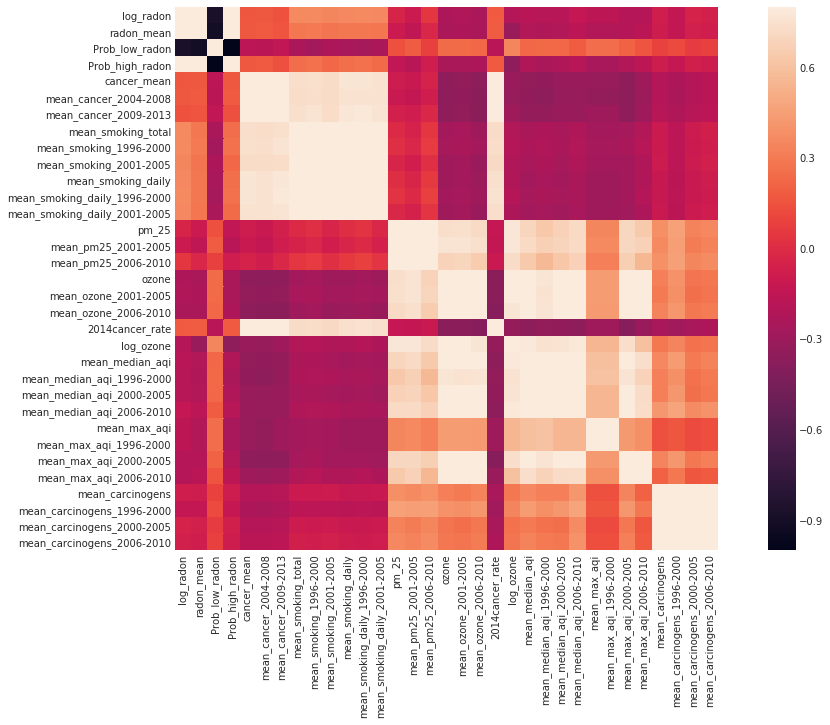

In [304]:
f, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(data.corr(), vmax=.8, square=True)

In [305]:
full_data = df.copy()
full_data = full_data[['log_radon','radon_mean']]
full_data = pd.concat([full_data, cr, sd,  s,  pm, oz, aq, tr], axis=1)
#, smoking_daily, pm_25, ozone
full_data.columns

Index(['log_radon', 'radon_mean', '2000cancer_rate', '2001cancer_rate',
       '2002cancer_rate', '2003cancer_rate', '2004cancer_rate',
       '2005cancer_rate', '2006cancer_rate', '2007cancer_rate',
       ...
       '2005_chems', '2006_chems', '2007_chems', '2008_chems', '2009_chems',
       '2010_chems', 'mean_carcinogens', 'mean_carcinogens_1996-2000',
       'mean_carcinogens_2000-2005', 'mean_carcinogens_2006-2010'],
      dtype='object', length=175)

In [672]:
def plot_top_correlation_matrix(data):
    corr = data.corr()
    corr = abs(corr['2014cancer_rate']).sort_values(ascending=False)
    corr = corr.head(15).index
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(12,8))
    cmap = sns.color_palette('coolwarm')
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5,
                yticklabels=True, annot=True, cbar_kws={'shrink':.5})
    plt.title('Top 15 Correlation Matrix')
    plt.xticks(rotation=90, fontsize=7)
    plt.yticks(rotation=0, fontsize=7)
    plt.tight_layout()
#plot_top_correlation_matrix(full_data)


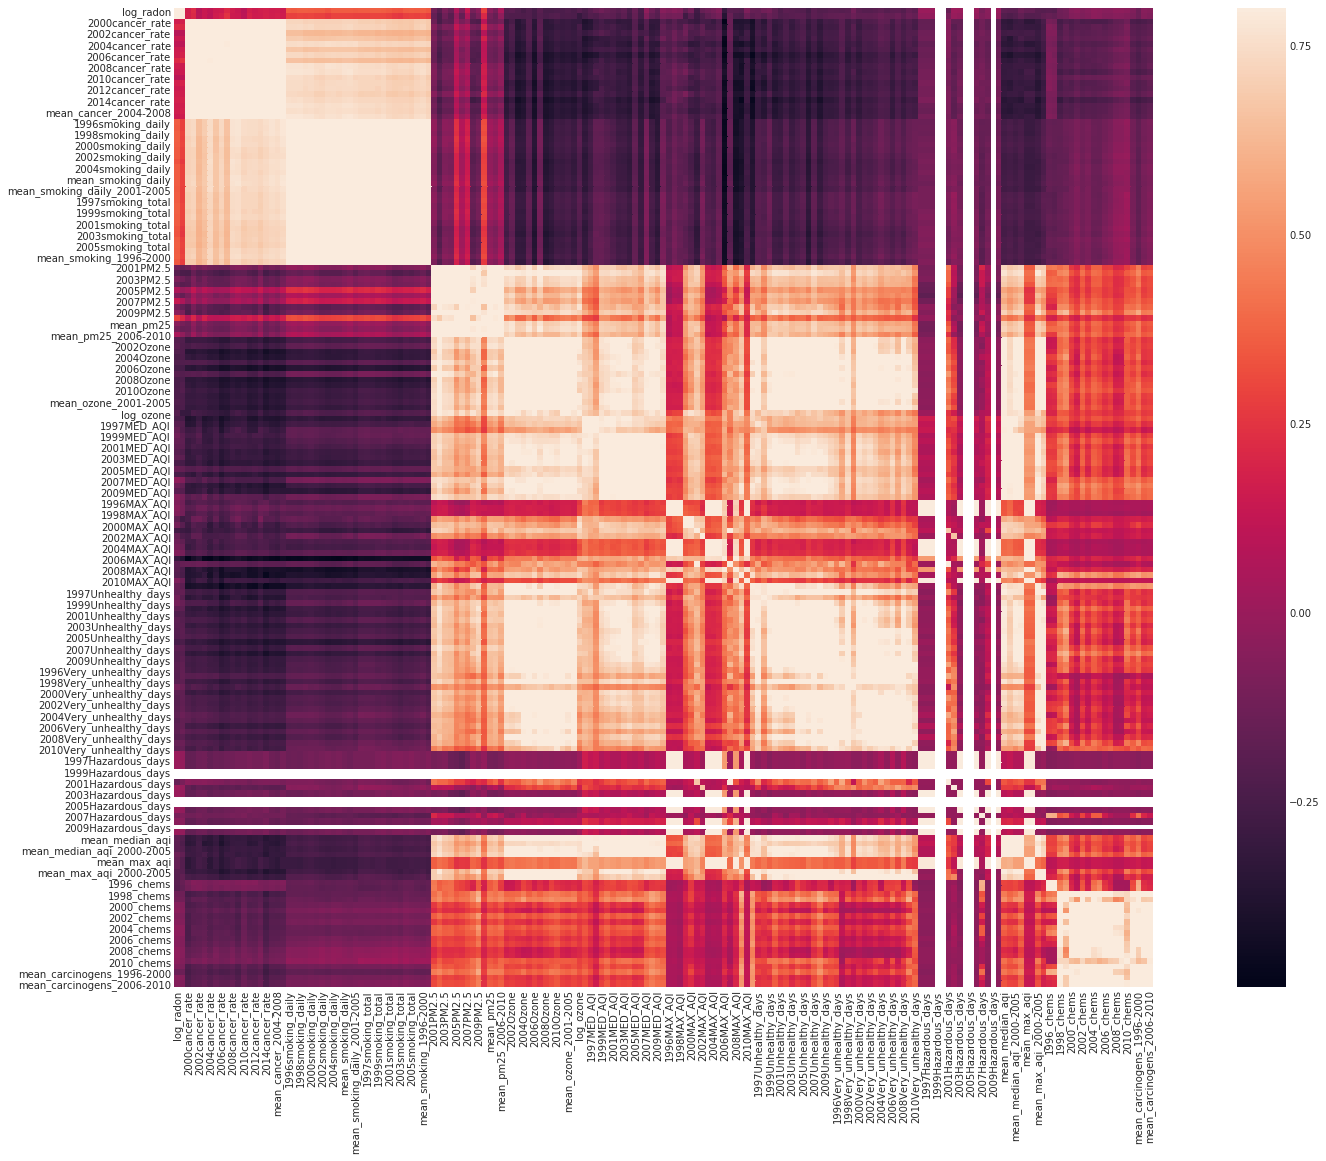

In [673]:
f, ax = plt.subplots(figsize=(30, 18))
corrmat = full_data.corr()
sns.heatmap(corrmat, vmax=.8, square=True)

In [674]:
#Looks like using smoking 1996-2000 could improve 

In [675]:
# k = 10 #number of variables for heatmap
#cols = corrmat.nlargest(10, '2014cancer_rate')['2014cancer_rate'].index
# cm = np.corrcoef(full_data[cols].values.T)
# sns.set(font_scale=1.25)
# sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

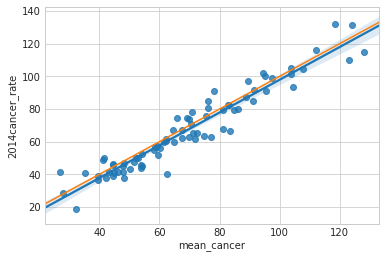

In [312]:
#fig, ax = plt.subplots()
sns.regplot(x="mean_cancer", y="2014cancer_rate", data=full_data)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)

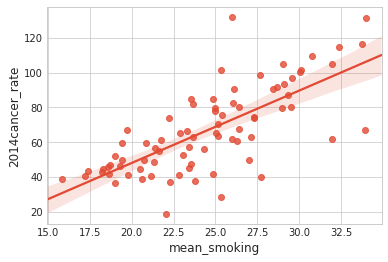

In [677]:
sns.regplot(x="mean_smoking", y="2014cancer_rate", data=full_data)

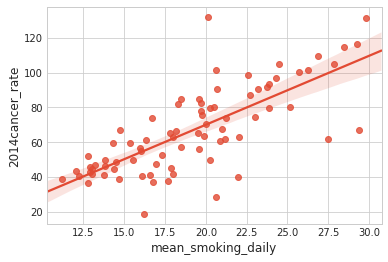

In [678]:
sns.regplot(x="mean_smoking_daily", y="2014cancer_rate", data=full_data)

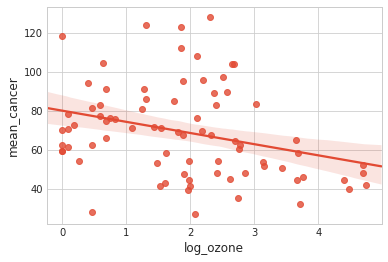

In [679]:
sns.regplot(x="log_ozone", y="mean_cancer", data=full_data)

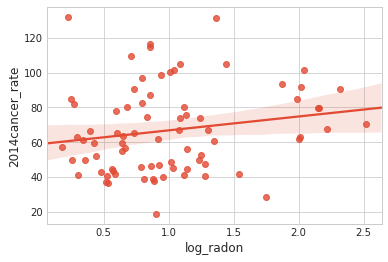

In [680]:
sns.regplot(x="log_radon", y="2014cancer_rate", data=full_data)

In [681]:
data.head()

,log_radon,radon_mean,Prob_low_radon,Prob_high_radon,cancer_mean,mean_cancer_2004-2008,mean_cancer_2009-2013,mean_smoking_total,mean_smoking_1996-2000,mean_smoking_2001-2005,...,mean_median_aqi_2000-2005,mean_median_aqi_2006-2010,mean_max_aqi,mean_max_aqi_1996-2000,mean_max_aqi_2000-2005,mean_max_aqi_2006-2010,mean_carcinogens,mean_carcinogens_1996-2000,mean_carcinogens_2000-2005,mean_carcinogens_2006-2010
State_and_county,,,,,,,,,,,,,,,,,,,,,
"Alameda County, CA",0.586860,0.798333,0.979249,0.020751,47.767503,47.320742,44.866175,18.65,19.78,17.52,...,41.0,45.2,181.133333,181.133333,3.466667,0.466667,57221.347924,111167.200,37831.058793,39943.566452
"Butte County, CA",0.396333,0.486364,0.972514,0.027486,83.502888,83.969759,76.978697,23.31,23.68,22.94,...,55.2,50.8,163.866667,163.866667,4.933333,0.200000,29533.686667,88601.060,0.000000,14766.843333
"Contra Costa County, CA",0.564366,0.758333,0.978727,0.021273,54.019373,53.652730,52.073776,18.29,19.46,17.12,...,42.4,40.4,168.133333,168.133333,3.066667,0.200000,55446.683699,63823.236,52978.461260,52492.518769
"Fresno County, CA",0.810091,1.248113,0.980274,0.019726,44.645124,45.267340,43.896261,20.63,21.26,20.00,...,102.0,79.6,215.466667,215.466667,58.600000,9.733333,48219.424950,84343.820,41414.043763,33559.918018
"Humboldt County, CA",0.293913,0.341667,0.966512,0.033488,69.828067,69.838713,64.176962,23.67,23.96,23.38,...,18.2,28.6,84.733333,84.733333,0.000000,0.000000,59657.794667,77441.502,81850.360000,39669.658333


Looking at individual counties

In [682]:
large_counties.sort_values(by='2014_pop', ascending=False)

,2000cancer_rate,2001cancer_rate,2002cancer_rate,2003cancer_rate,2004cancer_rate,2005cancer_rate,2006cancer_rate,2007cancer_rate,2008cancer_rate,2009cancer_rate,...,2002_chems,2003_chems,2004_chems,2005_chems,2006_chems,2007_chems,2008_chems,2009_chems,2010_chems,2014_pop
State_and_county,,,,,,,,,,,,,,,,,,,,,
"Los Angeles County, CA",41.821347,42.488942,40.851386,40.349560,40.895460,40.464429,39.679789,39.452148,40.091845,40.899524,...,7.731264e+05,5.697478e+05,6.188808e+05,7.954228e+05,747452.446083,597631.329476,3.593278e+05,2.502363e+05,2.321026e+05,9239968.0
"San Diego County, CA",56.766616,52.793490,52.097071,51.085840,49.249029,53.192666,52.387126,51.012487,48.509058,50.764356,...,1.485050e+05,1.406238e+05,1.594895e+05,1.224805e+05,93601.002779,81804.385360,6.272076e+04,8.316694e+04,7.262668e+04,2982272.0
"Orange County, CA",46.312628,47.028946,46.797983,43.114984,43.750049,44.216860,44.948250,44.548611,47.031488,47.670426,...,1.139000e+06,9.426803e+05,1.042145e+06,1.002499e+06,645510.208800,325608.622000,2.803103e+05,2.197807e+05,2.279847e+05,2855870.0
"Riverside County, CA",62.155826,58.392932,57.256422,58.984363,56.502896,53.111501,53.866834,48.333087,49.769826,49.470705,...,2.915794e+04,1.856665e+04,1.668324e+04,1.586243e+04,18804.027100,52949.664200,3.189445e+04,4.383994e+03,3.923077e+03,2114067.0
"San Bernardino County, CA",48.893010,46.628361,44.060671,44.525937,43.863691,44.291855,40.878560,39.454642,39.476278,43.198475,...,4.230141e+05,5.520292e+05,5.294019e+05,4.646165e+05,390784.279000,362651.626500,2.940979e+05,1.746723e+05,1.565010e+05,1965206.0
"King County, WA",57.849039,53.874089,56.576362,55.913442,54.357102,55.256374,54.142505,52.814253,53.759427,51.777918,...,9.315260e+04,7.996319e+04,9.748154e+04,8.209728e+04,87279.425551,56930.503680,2.251843e+04,1.507997e+04,1.784901e+04,1915469.0
"Santa Clara County, CA",37.924042,38.209044,39.416587,42.738845,38.661181,41.842952,42.042173,41.354512,36.244288,39.487020,...,9.014970e+04,7.587618e+04,9.544916e+04,8.573336e+04,92919.160000,83802.970000,6.800582e+04,4.351870e+04,3.441569e+04,1733459.0
"Wayne County, MI",81.467781,85.602401,83.895724,90.072846,83.374079,90.498061,91.022463,90.163452,95.117685,95.453912,...,3.431145e+05,3.527346e+05,2.127374e+05,3.706743e+05,601275.613000,565024.885000,1.949382e+06,1.813983e+06,2.324387e+06,1602365.0
"Alameda County, CA",55.799261,48.316280,51.706237,51.988670,47.381203,48.905861,46.937176,48.429809,44.949662,51.316649,...,3.388508e+04,3.561447e+04,3.177287e+04,4.059858e+04,21663.673000,19176.398300,2.917850e+04,2.658288e+04,1.672747e+04,1478621.0


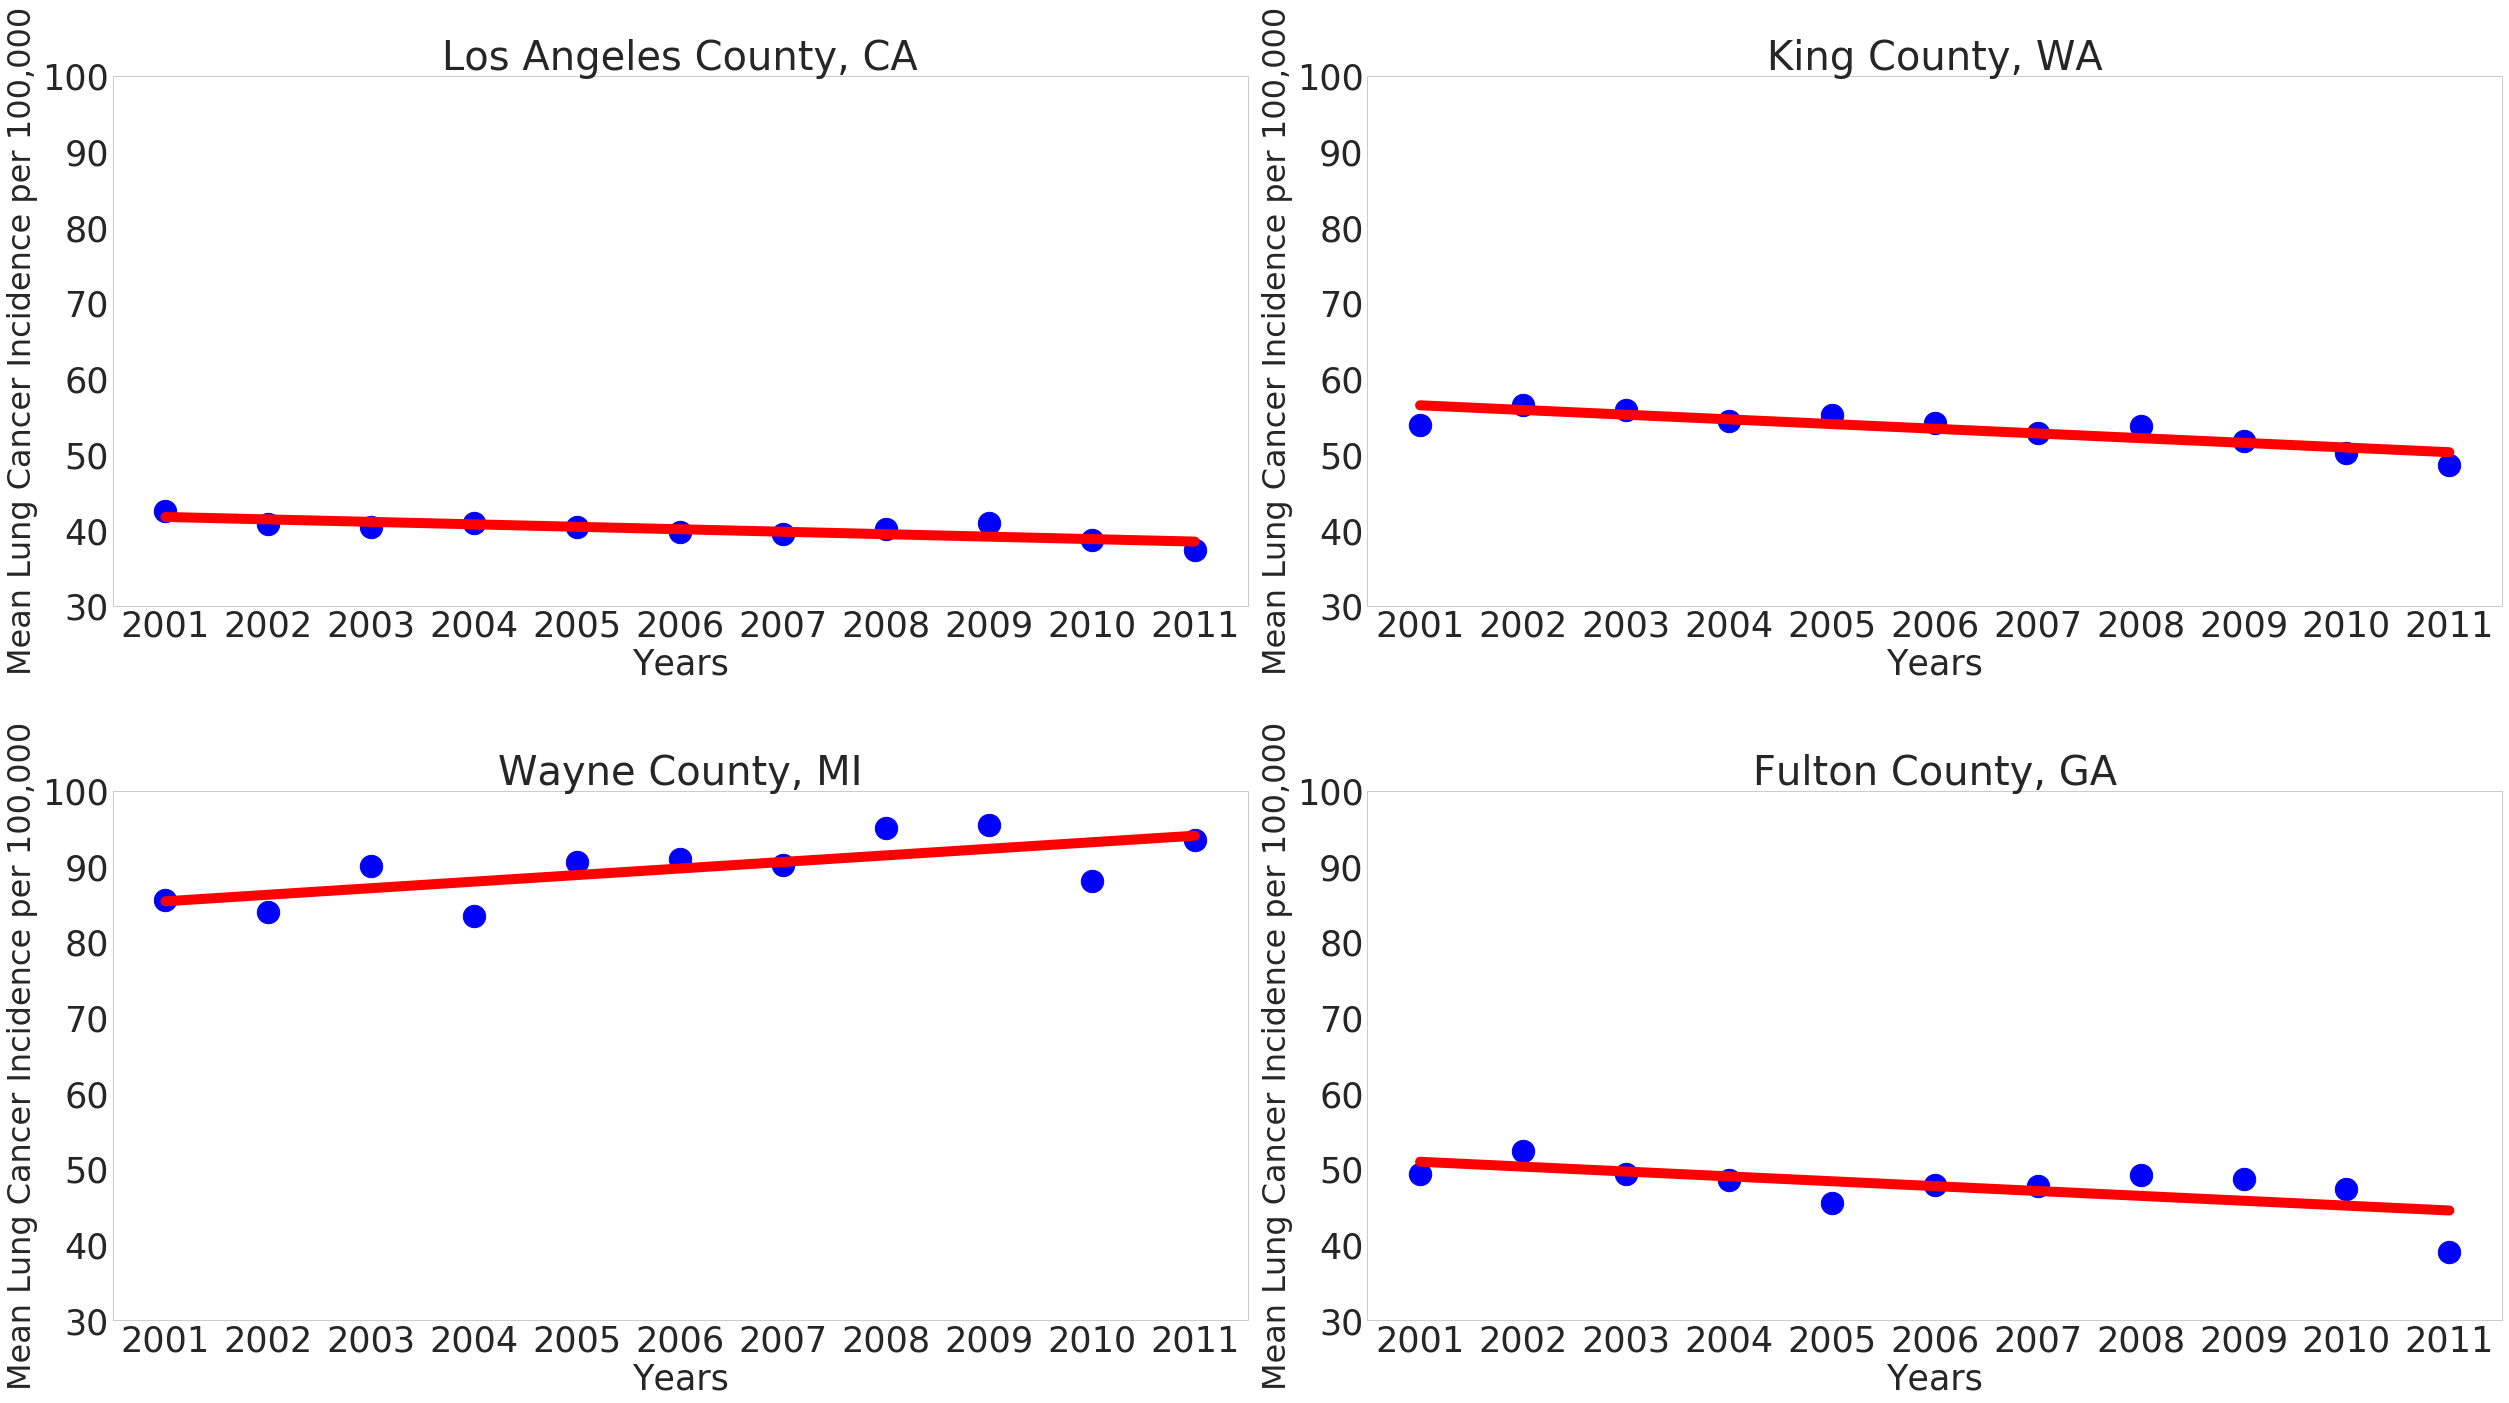

In [81]:
# counties = ['Los Angeles County, CA','King County, WA', 'Wayne County, MI', 'Fulton County, GA']
# for county in counties:
#     fig, ax = plt.subplots(figsize=(12,6))
#     county_data = large_counties.loc[county][:15]
#     ax.scatter([str(i) for i in county_data.index.str[:4]],county_data)
#     X = np.array([int(i) for i in county_data.index.str[:4][:14]])
#     Y = np.array(county_data[:14])
#     fit = np.polyfit(X, Y, deg=1)
#     ax.plot(X, fit[0] * X + fit[1], color='red')
#     plt.xlabel('Years', fontsize=15)
#     plt.ylabel('Mean Lung Cancer Incidence per 100,000', fontsize=15)
#     plt.title(county, fontsize=20)
#     plt.tick_params(labelsize=12)
counties = ['Los Angeles County, CA','King County, WA', 'Wayne County, MI', 'Fulton County, GA']
fig, ax = plt.subplots(2,2,figsize=(35,20))
counter = 1
for county in counties:
    county_data = large_counties.loc[county][1:12]
    plt.subplot(2,2,counter)
    plt.grid(False)
    plt.scatter([str(i) for i in county_data.index.str[:4]],county_data, color='blue', s=500)
    X = np.array([int(i) for i in county_data.index.str[:4][:14]])
    Y = np.array(county_data[:14])
    fit = np.polyfit(X, Y, deg=1)
    plt.plot(X, fit[0] * X + fit[1], color='red', lw=10)
    plt.xlabel('Years', fontsize=35)
    plt.ylabel('Mean Lung Cancer Incidence per 100,000', fontsize=32)
    plt.title(county, fontsize=40)
    plt.tick_params(labelsize=35)
    plt.ylim([30,100])
    counter += 1
plt.tight_layout() 

In [684]:
# fig, ax = plt.subplots(figsize=(12,6))
# county_data = df[:14]
# ax.scatter([str(i) for i in df.columns.str[:4]],county_data)
# X = np.array([int(i) for i in df.columns.str[:4][:14]])
# Y = np.array(df[:14])
# fit = np.polyfit(X, Y, deg=1)
# ax.plot(X, fit[0] * X + fit[1], color='red')
# plt.xlabel('Years', fontsize=10)
# plt.ylabel('Mean Lung Cancer Incidence per 100,000', fontsize=10)
# plt.title(county)
[int(i) for i in df.columns.str[:4][:14]]
df[:14]

,2000cancer_rate,2001cancer_rate,2002cancer_rate,2003cancer_rate,2004cancer_rate,2005cancer_rate,2006cancer_rate,2007cancer_rate,2008cancer_rate,2009cancer_rate,...,2003_chems,2004_chems,2005_chems,2006_chems,2007_chems,2008_chems,2009_chems,2010_chems,2014_pop,log_radon
State_and_county,,,,,,,,,,,,,,,,,,,,,
"Alameda County, CA",55.799261,48.316280,51.706237,51.988670,47.381203,48.905861,46.937176,48.429809,44.949662,51.316649,...,3.561447e+04,3.177287e+04,4.059858e+04,2.166367e+04,1.917640e+04,2.917850e+04,2.658288e+04,1.672747e+04,1478621.0,0.586860
"Butte County, CA",94.697434,94.086608,92.291507,83.222606,86.358623,77.764119,88.089879,75.413047,92.223125,79.626167,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,198402.0,0.396333
"Contra Costa County, CA",54.470461,60.250146,53.476918,59.441172,52.195433,52.351671,54.754335,56.780346,52.181867,49.041806,...,5.350639e+04,5.695503e+04,4.261143e+04,4.967529e+04,4.198562e+04,5.477518e+04,5.635625e+04,4.489943e+04,1005263.0,0.564366
"Fresno County, CA",45.801260,45.632278,43.988517,43.791674,46.571858,45.617614,43.898256,43.306810,46.942163,43.300003,...,4.395898e+04,4.370348e+04,4.216363e+04,3.421332e+04,3.070648e+04,1.901903e+04,2.991902e+03,7.571318e+03,891330.0,0.810091
"Humboldt County, CA",71.958375,83.124216,80.757882,71.674091,82.630717,68.442626,80.246493,56.060181,61.813549,68.788133,...,6.104410e+04,9.979080e+04,8.248860e+04,5.149170e+04,3.804254e+04,8.855575e+03,1.003500e+01,7.760000e+00,121751.0,0.293913
"Kern County, CA",53.931663,57.791165,51.292469,55.161059,52.967828,45.088508,44.741246,45.812113,48.758015,46.377887,...,1.167447e+06,1.000490e+06,5.890316e+05,4.848028e+05,6.002497e+05,5.522710e+05,6.804459e+05,2.886481e+06,816005.0,0.889947
"Kings County, CA",30.038125,31.607228,29.548863,34.435015,32.729577,37.892619,35.203640,28.586624,34.204451,26.267747,...,4.582895e+06,1.888380e+06,1.823611e+06,3.038444e+06,2.552402e+06,5.078733e+06,3.522777e+06,2.057570e+06,118474.0,0.906240
"Los Angeles County, CA",41.821347,42.488942,40.851386,40.349560,40.895460,40.464429,39.679789,39.452148,40.091845,40.899524,...,5.697478e+05,6.188808e+05,7.954228e+05,7.474524e+05,5.976313e+05,3.593278e+05,2.502363e+05,2.321026e+05,9239968.0,0.534882
"Madera County, CA",41.266476,66.092801,53.751295,48.968645,59.807740,49.175771,55.005501,49.977065,45.834766,61.648150,...,1.759262e+05,1.684055e+05,1.911425e+05,1.160800e+05,8.184500e+04,7.209530e+04,6.400300e+04,4.560800e+04,141123.0,1.282091


In [865]:
data_bic = data[['cancer_mean','mean_carcinogens_2006-2010','log_radon','mean_smoking_total','pm_25','ozone','mean_median_aqi','2014cancer_rate']]

In [866]:
y = data_bic.pop('2014cancer_rate')
X = data_bic
X.columns

Index(['cancer_mean', 'mean_carcinogens_2006-2010', 'log_radon',
       'mean_smoking_total', 'pm_25', 'ozone', 'mean_median_aqi'],
      dtype='object')

Difference between large, medium and small counties?

In [867]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [868]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test) 

In [869]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [870]:
scores = cross_val_score(lm, X, y, cv=5)
print(scores.mean())

0.717491103854


In [871]:
X.head()

,cancer_mean,mean_carcinogens_2006-2010,log_radon,mean_smoking_total,pm_25,ozone,mean_median_aqi
State_and_county,,,,,,,
"Alameda County, CA",47.767503,39943.566452,0.586860,18.65,11.866575,5.7,41.800000
"Butte County, CA",83.502888,14766.843333,0.396333,23.31,11.164623,19.7,48.400000
"Contra Costa County, CA",54.019373,52492.518769,0.564366,18.29,10.860503,6.3,41.000000
"Fresno County, CA",44.645124,33559.918018,0.810091,20.63,17.571905,80.1,88.266667
"Humboldt County, CA",69.828067,39669.658333,0.293913,23.67,9.092561,0.0,22.266667


Lasso Regression

In [888]:
lasso = Lasso(alpha=0.2)
lasso.fit(X_train, y_train)

Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [889]:
cross_val_score(lasso, lasso.predict(X_test).reshape(-1,1),y_test.values.reshape(-1,1), cv=5).mean()

0.81667571122819405

In [890]:
lasso.intercept_

66.24937892282037

In [891]:
variables = np.array(list(zip(X.columns,lasso.coef_)))
# for i in variables:
# #     if i[1]=='0.0' or i[1]=='-0.0':
# #         variables.remove(i)
#print(np.sort(variables, axis=0))
print(variables)

[['cancer_mean' '21.4823910844']
 ['mean_carcinogens_2006-2010' '-0.0']
 ['log_radon' '-0.0']
 ['mean_smoking_total' '0.844429513727']
 ['pm_25' '-1.79140722672']
 ['ozone' '-0.0']
 ['mean_median_aqi' '0.0']]


In [892]:
regr = ElasticNet(alpha=0.3, l1_ratio=0.7, random_state=0)
regr.fit(X_train, y_train)

ElasticNet(alpha=0.3, copy_X=True, fit_intercept=True, l1_ratio=0.7,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)

In [893]:
cross_val_score(regr, regr.predict(X_test).reshape(-1,1),y_test.values.reshape(-1,1), cv=5).mean()

0.79712674767880087

In [894]:
mse = mean_squared_error(y_test.values.reshape(-1,1), regr.predict(X_test).reshape(-1,1))

In [895]:
np.sqrt(mse)

9.8698557442928401

In [319]:
df_lung = pd.read_csv('lung_tri.csv')

df_lung.index = df_lung['State_and_county']
cancer_mean = pd.DataFrame(df_lung.groupby('State_and_county')['cancer_incidence'].mean()).reset_index()

df = df_lung[['cancer_incidence','smoking','smoking_daily','pm25','ozone', 'radon_mean','Prob_low_radon','Prob_high_radon','Days PM2.5','Median AQI','Max AQI','ON-SITE_RELEASE_TOTAL']]

df_new = df[df.index.value_counts()>10]

/home/davidhenslovitz/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'State_and_county' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  after removing the cwd from sys.path.
/home/davidhenslovitz/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [320]:
y = df_new.pop('cancer_incidence')
X = df_new.copy()

In [321]:
model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(X, y)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

/home/davidhenslovitz/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=5.596e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)


In [322]:
model_bic.criterion_.min()

590.03271165043066

In [326]:
smoking_group = ['smoking','smoking_daily']
radon_group = ['radon_mean', 'Prob_low_radon', 'Prob_high_radon']
pm25_group = ['pm25','Days PM2.5']
aqi_group = ['Median AQI','Max AQI']
ozone_group = ['ozone']
tri_group = ['ON-SITE_RELEASE_TOTAL']



In [355]:
bic_features = pd.DataFrame()
feature_list = []
bic_list = []
for s in smoking_group:
    #for a in aqi_group:
    for r in radon_group:
    #for t in tri_group:
    #for p in pm25_group:
            #for o in ozone_group:
        X_new = X[[s,r]]
        #X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3)

        model_bic = LassoLarsIC(criterion='bic')
        t1 = time.time()
        model_bic.fit(X_new, y)
        t_bic = time.time() - t1
        alpha_bic_ = model_bic.alpha_
        feature_list.append([s,r])
        bic_list.append(model_bic.criterion_.min())

In [356]:
bic_features['features'] = feature_list
bic_features['BIC'] = bic_list
bic_features.sort_values(by='BIC', ascending=True)

,features,BIC
4,"[smoking_daily, Prob_low_radon]",628.236039
5,"[smoking_daily, Prob_high_radon]",628.236039
3,"[smoking_daily, radon_mean]",630.537383
1,"[smoking, Prob_low_radon]",670.477095
2,"[smoking, Prob_high_radon]",670.477095
0,"[smoking, radon_mean]",671.651033


In [357]:
bic_features.sort_values(by='BIC', ascending=True).iloc[0][0]

['smoking_daily', 'Prob_low_radon']

In [701]:
def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_

    
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')
    #Set x-axis scale
    plt.xlim(0,5)

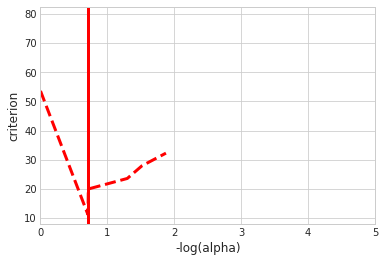

In [702]:
plot_ic_criterion(model_bic, 'BIC', 'r')

In [703]:
model_bic.alpha_

0.19497163908705845

In [704]:
X.columns

Index(['cancer_mean', 'mean_carcinogens_2006-2010', 'log_radon',
       'mean_smoking_total', 'pm_25', 'ozone', 'mean_median_aqi'],
      dtype='object')

In [767]:
X = data[['log_radon', 'radon_mean', 'Prob_low_radon', 'Prob_high_radon','cancer_mean', 'mean_cancer_2004-2008', 'mean_cancer_2009-2013','mean_smoking_total', 'mean_smoking_1996-2000','mean_smoking_2001-2005', 'mean_smoking_daily','mean_smoking_daily_1996-2000', 'mean_smoking_daily_2001-2005', 'pm_25','mean_pm25_2001-2005', 'mean_pm25_2006-2010', 'mean_median_aqi', 'mean_median_aqi_1996-2000','mean_median_aqi_2000-2005', 'mean_median_aqi_2006-2010','mean_max_aqi', 'mean_max_aqi_1996-2000', 'mean_max_aqi_2000-2005','mean_max_aqi_2006-2010', 'mean_carcinogens','mean_carcinogens_1996-2000', 'mean_carcinogens_2000-2005','mean_carcinogens_2006-2010', '2014cancer_rate']]
y = X.pop('2014cancer_rate')

In [768]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [769]:
radon_group = ['log_radon', 'radon_mean', 'Prob_low_radon', 'Prob_high_radon']
cancer_group = ['cancer_mean', 'mean_cancer_2004-2008', 'mean_cancer_2009-2013']
smoking_group = ['mean_smoking_total', 'mean_smoking_1996-2000','mean_smoking_2001-2005', 'mean_smoking_daily','mean_smoking_daily_1996-2000', 'mean_smoking_daily_2001-2005']
pm_25_group = ['pm_25','mean_pm25_2001-2005', 'mean_pm25_2006-2010']
#ozone_group = ['ozone','mean_ozone_2001-2005', 'mean_ozone_2006-2010', 'log_ozone']
aqi_group = ['mean_median_aqi', 'mean_median_aqi_1996-2000','mean_median_aqi_2000-2005', 'mean_median_aqi_2006-2010','mean_max_aqi', 'mean_max_aqi_1996-2000', 'mean_max_aqi_2000-2005','mean_max_aqi_2006-2010']
tri_group = ['mean_carcinogens','mean_carcinogens_1996-2000', 'mean_carcinogens_2000-2005','mean_carcinogens_2006-2010']

In [774]:
bic_features = pd.DataFrame()
feature_list = []
bic_list = []
for c in cancer_group:
    for s in smoking_group:
        for a in aqi_group:
            for r in radon_group:
#        for t in tri_group:
#    for p in pm_25_group:
                        #for o in ozone_group:
                X_new = X[[c ,s, a,r]]
                #X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3)

                model_bic = LassoLarsIC(criterion='bic')
                t1 = time.time()
                model_bic.fit(X_new, y)
                t_bic = time.time() - t1
                alpha_bic_ = model_bic.alpha_
                feature_list.append([c ,s, a, r])
                bic_list.append(model_bic.criterion_.min())


In [775]:
bic_features['features'] = feature_list
bic_features['BIC'] = bic_list
bic_features.sort_values(by='BIC', ascending=True)

,features,BIC
501,"[mean_cancer_2009-2013, mean_smoking_daily, me...",10.962522
433,"[mean_cancer_2009-2013, mean_smoking_1996-2000...",10.962522
529,"[mean_cancer_2009-2013, mean_smoking_daily_199...",10.962522
541,"[mean_cancer_2009-2013, mean_smoking_daily_199...",10.962522
421,"[mean_cancer_2009-2013, mean_smoking_1996-2000...",10.962522
445,"[mean_cancer_2009-2013, mean_smoking_1996-2000...",10.962522
453,"[mean_cancer_2009-2013, mean_smoking_2001-2005...",10.962522
517,"[mean_cancer_2009-2013, mean_smoking_daily_199...",10.962522
549,"[mean_cancer_2009-2013, mean_smoking_daily_200...",10.962522
413,"[mean_cancer_2009-2013, mean_smoking_total, me...",10.962522


In [749]:
bic_features.sort_values(by='BIC', ascending=True).iloc[0][0]

['mean_cancer_2009-2013',
 'mean_smoking_daily_2001-2005',
 'mean_max_aqi_1996-2000']

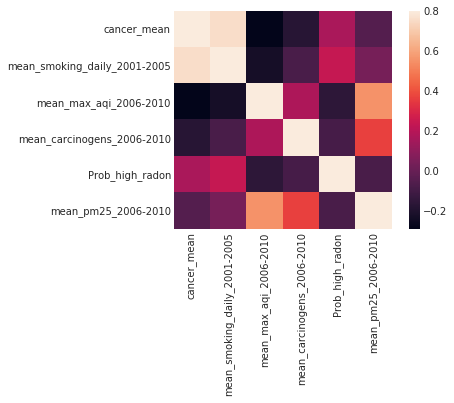

In [748]:
corrmat = data[['cancer_mean',
 'mean_smoking_daily_2001-2005',
 'mean_max_aqi_2006-2010',
 'mean_carcinogens_2006-2010',
 'Prob_high_radon',
 'mean_pm25_2006-2010']].corr()
sns.heatmap(corrmat, vmax=.8, square=True)

In [750]:
features1 = ['cancer_mean','mean_smoking_daily_2001-2005','mean_max_aqi_2006-2010','mean_carcinogens_2006-2010','Prob_high_radon','mean_pm25_2006-2010','mean_ozone_2006-2010']
features1_score = '11.26'
features2 = ['cancer_mean','mean_smoking_daily_2001-2005','mean_max_aqi_2006-2010','mean_carcinogens_2006-2010','Prob_high_radon','mean_pm25_2006-2010']
features2_score = '11.26'
features3 = ['mean_cancer_2009-2013']
features3_score = '10.83'
features4 = ['mean_cancer_2009-2013', 'mean_max_aqi_1996-2000']
features4_score = '10.84'
features5 = ['mean_cancer_2009-2013', 'mean_smoking_daily_2001-2005']
features5_score = '10.86'
features6 = ['cancer_mean', 'mean_carcinogens_2006-2010']
features6_score = '11.26'
features7 = ['cancer_mean', 'Prob_low_radon']
features7_score = '10.90'
features8 = ['cancer_mean', 'mean_pm25_2001-2005']
features8_score = '10.99'
features9 = ['mean_cancer_2009-2013','mean_smoking_daily_2001-2005','mean_max_aqi_1996-2000']
features9_score = '10.86'

In [ ]:
#Modeling

In [781]:
pd.melt(df_lung_overall, id_vars=['fips'], value_vars=[2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014])


NameError: name 'df_lung_overall' is not defined

In [82]:
#pd.merge(df_lung_overall, df_overall, how='left', on=['State_and_county','variable'])

$$
y_i = \alpha + \beta x_i
$$

$$
y_i = \alpha_i + \beta_i x_i + e_i
$$

$$
\alpha_c \sim \mathcal{N}(\mu_\alpha,\,\sigma_\alpha^{2})
$$

$$
\beta_c \sim \mathcal{N}(\mu_\beta,\,\sigma_\beta^{2})
$$

$$
RMSE = \sqrt{\frac{\sum_{i=1}^n {(\hat{y}-y}^2)}{n}}
$$

$$
\alpha_s \sim \mathcal{N}(\mu_\alpha,\,\sigma_\alpha^{2})
$$

$$
\beta_s \sim \mathcal{N}(\mu_\beta,\,\sigma_\beta^{2})
$$

In [371]:
df_lung = pd.read_csv('lung_tri.csv')

In [372]:
cancer_mean = pd.DataFrame(df_lung.groupby('State_and_county')['cancer_incidence'].mean()).reset_index()
df_lung = pd.merge(df_lung, cancer_mean, how='left', on='State_and_county')
df_lung = df_lung.sort_values(by='cancer_incidence_y')
#df_lung = df_lung.pivot(index='State_and_county', columns='year', values='cancer_incidence_x').reset_index()
#df_lung.drop(df_lung[pd.isnull(df_lung).any(axis=1)].index, inplace=True)
#df_lung.shape
df_lung.State.unique()
#pd.DataFrame(df_lung.groupby('State_and_county')['cancer_incidence'].mean())

array(['CA', 'IA', 'NM', 'GA', 'WA', 'KY', 'MI'], dtype=object)

Text(0.5,1,'Distribution of County Lung Cancer Incidence per 100,000 People (2001-2011)')

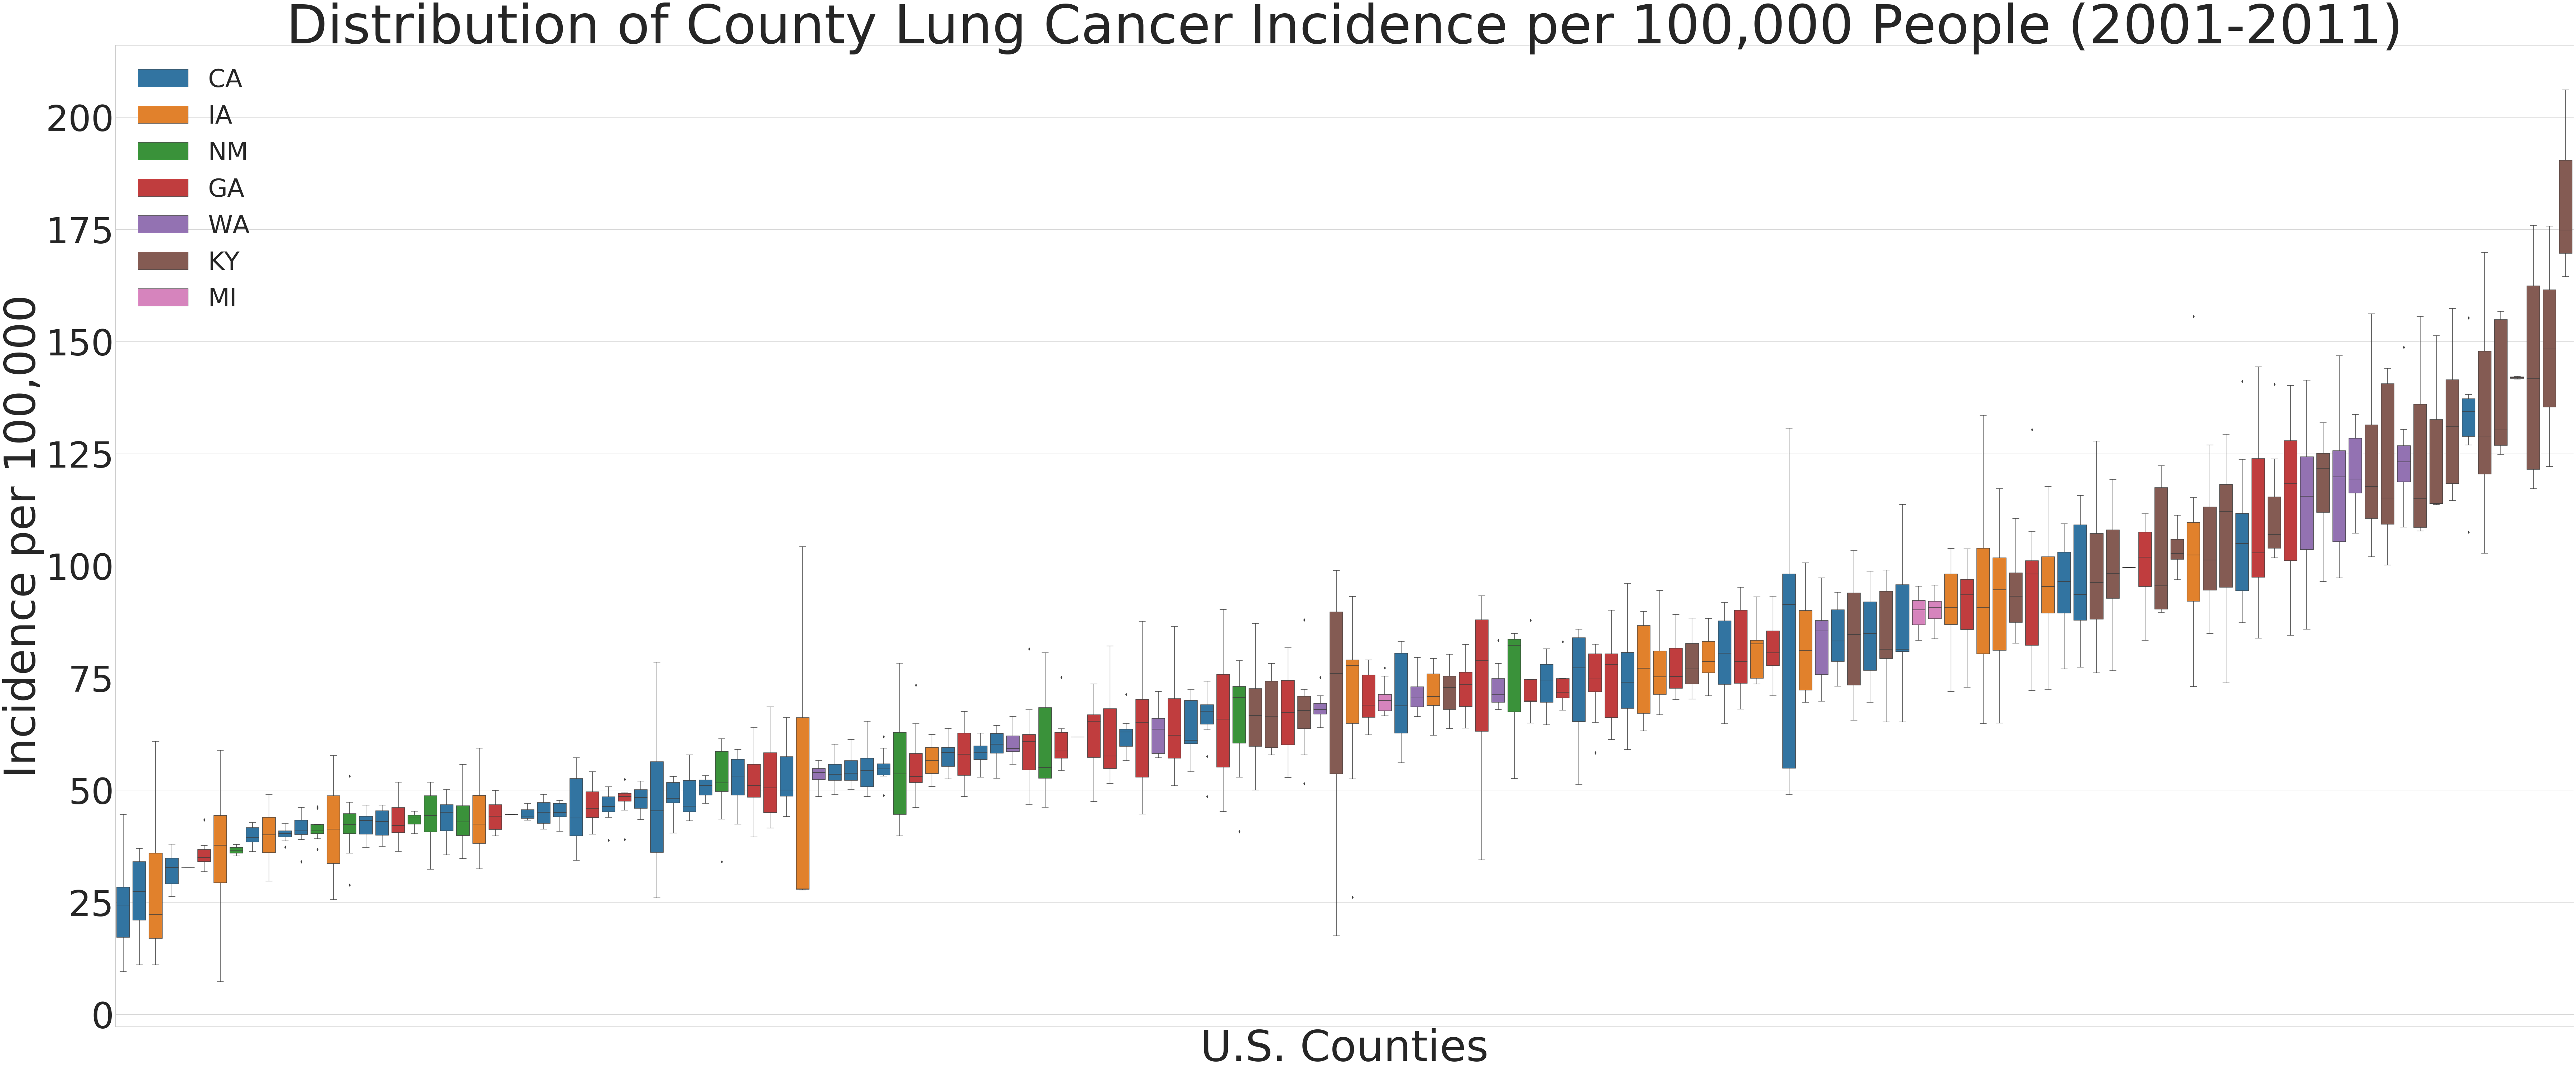

In [394]:
fig = plt.subplots(figsize=(100,40))
ax = sns.boxplot(x='State_and_county', y='cancer_incidence_x', hue='State',data=df_lung, dodge=False)

ax.set_xlabel('U.S. Counties', fontsize=120)
ax.set_ylabel('Incidence per 100,000', fontsize=120)
#ax.set_yticklabels(ax.get_yticklabels(),rotation=90, fontsize=40)
#ax.set_xticklabels([str(i)[-4:-2] for i in ax.get_xticklabels()],rotation=60, fontsize=20)
#colors = {'KY':'red', 'CA':'blue', 'MI':'green', 'NM':'orange','GA':'brown','WA':'yellow', 'IA':'purple'}
ax.tick_params(labelsize=100)
plt.xticks([], [])
plt.legend(loc='upper left', fontsize=70)
plt.tight_layout()
plt.title('Distribution of County Lung Cancer Incidence per 100,000 People (2001-2011)', fontsize=150)